Name: Akshay Sanghai

Email: sanghai.akshay@gmail.com

###Project Description:

Image caption generator based on Vinyals model (https://github.com/anuragmishracse/caption_generator)

In this tutorial, we will learn to build a image caption generator based on Vinyals model (https://arxiv.org/pdf/1411.4555.pdf). 

This is how the model looks like. We encode the image using a CNN (densenet in this case) and use RNN (LSTM in this case) to generate words. We will go into the details of how we encode images and then train the model using LSTMs.

![](https://shadowthink.com/images/cv/nic.png)

We will use Flickr8k dataset to train our machine learning model. Although many other image captioning datasets (Flickr30k, COCO) are available, Flickr8k is chosen because it takes only a few hours of training on GPU to produce a good model. The dataset contains 8000 of images each of which has 5 captions by different people. Having more than one caption for each image is desirable because an image can be described in many ways.

This is how the flow of tutorial looks:
1. Download Flickr dataset
2. Preprocess the dataset
  - preprocess images 
  - preprocess captions
3. Get training data
4. Create tokenizer to process captions
5. Define batch generator
6. Define the caption generator model
7. Find the optimum learning rate
8. Calculate BLEU-1 score
9. Different things I tried
10. What else we can try?
11. References and further reading

We will go through each of the steps in detail covering why they were done and how they were done. Don't worry about the terms used above, we will cover all of them and I will also include links for further reading.



Let's start with importing all the modules that we will use.

In [0]:
!pip install keras
import pickle
from keras.preprocessing import image
import numpy as np 
from keras.applications.imagenet_utils import preprocess_input	
import matplotlib.pyplot as plt
from keras.models import Model
from keras.applications.densenet import DenseNet121
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import image, sequence
from keras.layers import Embedding, Input
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Merge, Activation, Flatten
from keras.layers import (BatchNormalization, Concatenate, Dense, LSTM,TimeDistributed)
from keras.models import Model
from keras.optimizers import Adam
import math
from keras.callbacks import LambdaCallback
import keras.backend as K
import tensorflow as tf
import nltk

Using TensorFlow backend.


In [0]:
!ls -lrt

total 4
drwxr-xr-x 3 root root 4096 Jun 28 16:55 datalab


### 1. Download Flickr dataset
The dataset is available after filling out this [form](https://forms.illinois.edu/sec/1713398). Basically, we will be getting the links mentioned below. After downloading the dataset, we unzip the data. 

Let's review what is there in the files:
- Flicker8k_Dataset: This folder has all the images.
- Flickr8k_text: This folder has several files
 - Flickr_8k.trainImages.txt : This file has list of image names separated by line to be used for training.
 - Flickr_8k.testImages.txt : This file has list of image names separated by line to be used for testing.
 - Flickr8k.token.txt : This file has image caption pair separated by line in the format mentioned below.
   - "1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way ."

In [0]:
!wget  http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_Dataset.zip
!wget  http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_text.zip
!unzip -q Flickr8k_Dataset.zip
!mkdir Flickr8k_text && unzip -q Flickr8k_text.zip -d Flickr8k_text
!ls

--2018-06-30 07:51:50--  http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_Dataset.zip
Resolving nlp.cs.illinois.edu (nlp.cs.illinois.edu)... 192.17.58.132
Connecting to nlp.cs.illinois.edu (nlp.cs.illinois.edu)|192.17.58.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115419746 (1.0G) [application/zip]
Saving to: ‘Flickr8k_Dataset.zip’

Flickr8k_Dataset.zi  24%[===>                ] 260.18M  18.7MB/s    eta 2m 15s 

Flickr8k_Dataset.zi 100%[===================>]   1.04G  66.7MB/s    in 2m 6s   

2018-06-30 07:53:56 (8.43 MB/s) - ‘Flickr8k_Dataset.zip’ saved [1115419746/1115419746]

--2018-06-30 07:53:57--  http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_text.zip
Resolving nlp.cs.illinois.edu (nlp.cs.illinois.edu)... 192.17.58.132
Connecting to nlp.cs.illinois.edu (nlp.cs.illinois.edu)|192.17.58.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2340801 (2.2M) [application/zip]
Saving to: ‘Flickr8k_text.zip’

Flickr8k_text.zip   100%[===================>]   2.23M  4.35MB/s    in 0.5s    

2018-06-30 07:53:58 (4.35 MB/s) - ‘Flickr8k_text.zip’ saved [2340801/2340801]

datalab		   Flickr8k_Dataset.zip  Flickr8k_text.zip
Flicker8k_Dataset  Flickr8k_text	 __MACOSX


### 2. Preprocess the dataset
There are few things that we need to do here. 
- First is we need to get image features for each image. If you remember, we mentioned we will be using Densenet as image encoder. Processing the image through CNN takes some time, so we preprocess and collect the 1024-sized vector for each image. Consider this as a representation of image in a smaller dimension. Each image is loaded as 224x224x3 matrix and then converted to 1024-sized vector using the Densenet Model.

- Second, we need to process the captions and add a "EOS" end of sentence character. We use "zeosz" for EOS. We don't use any start character. We feed the image encoding at t=0 and feed the first word at t=1. We need some more processing for captions which is done in step 4.

- Third, we need to create files for training and test dataset. The lines of these files are in this format.
  - "3107889179_106d223345.jpg	A grandmother and a small child are sitting at a table being served by a woman in a black shirt . zeosz"
  - Flickr8k_text/flickr_8k_train_dataset.txt for training
  - Flickr8k_text/flickr_8k_test_dataset.txt for testing
  
We have done this in 3 steps. Lets go through the code.

This section of code from https://github.com/anuragmishracse/caption_generator/blob/master/caption_generator/prepare_dataset.py

*load_image function* takes the image path and returns 224x224x3 matrix for the image. We will use this function when we get the encoding of the image.

In [0]:
def load_image(path):
    img = image.load_img(path, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return np.asarray(x)

*load_encoding_model*: This function is used to load the DenseNet121 model with pretrained weights and return a model which takes image input and outputs the last layer of DenseNet model. 

*get_encoding_model*: This function takes the image encoding model and img matrix and returns a 1024 vector representation of the image. We have done one reshaping, which changes dimension from (1,1024) to (1024,).

In [0]:
counter = 0

def load_encoding_model():
  image_model = DenseNet121(weights='imagenet', include_top=False, pooling='avg')
  for layer in image_model.layers:
    layer.trainable = False
  transfer_layer = image_model.layers[-1]
  image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)
  return image_model_transfer

def get_encoding(model, img):
  global counter
  counter += 1
  image = load_image('Flicker8k_Dataset/'+str(img))
  pred = model.predict(image)
  print( pred.shape)
  pred = np.reshape(pred, pred.shape[1])
  print("Encoding image: "+str(counter))
  print( pred.shape)
  return pred

*L1-L6*: Here we open the trainImages and textImages file and save the list of train images in train_imgs and the list of test images in test_imgs.

*L10-L11*: Here we define the files for training and test dataset. 

*L15-L23*: Here we define a dictionary "data". The key of this dictionary is an image name and value is the list of captions. For each image, we have 5 captions. This data is present in "Flickr8k.token.txt", we are extracting it to separate train and test dataset and also add EOS character ("zeosz") at the end of each caption.

*L30-L36*: encoded_images is a dictionary for which key is image name and value is the encoding of the image (1024-sized vector). For each of the image in train_imgs list, we find the encoding. Then we write a line in the training dataset file, which has image name and caption separated by tab.

*L40-L46*: Same as above for test data.

*L48-L49*: Finally we dump the encoded_images dictionary in a pickle file. We can use this file to get the image encoding.

In [0]:
no_imgs = -1
with open('Flickr8k_text/Flickr_8k.trainImages.txt','r') as f_train_images:
	train_imgs = f_train_images.read().strip().split('\n') if no_imgs == -1 else f_train_images.read().strip().split('\n')[:no_imgs]
	
with open('Flickr8k_text/Flickr_8k.testImages.txt','r') as f_test_images:
	test_imgs = f_test_images.read().strip().split('\n') if no_imgs == -1 else f_test_images.read().strip().split('\n')[:no_imgs]

print("number of training images "+ str(len(train_imgs)))

f_train_dataset = open('Flickr8k_text/flickr_8k_train_dataset.txt','w')
f_test_dataset = open('Flickr8k_text/flickr_8k_test_dataset.txt','w')

f_captions = open('Flickr8k_text/Flickr8k.token.txt', 'r')
captions = f_captions.read().strip().split('\n')
data = {}
for row in captions:
  #print(row)
  row = row.split("\t")
  row[0] = row[0][:len(row[0])-2]  #get image name
  try:
    data[row[0]].append(row[1])    #image name with multiple captions
  except:
    data[row[0]] = [row[1]]
f_captions.close()

encoded_images = {}
encoding_model = load_encoding_model()

c_train = 0
for img in train_imgs:
	encoded_images[img] = get_encoding(encoding_model, img)
	for capt in data[img]:
		caption = capt+" zeosz"
		f_train_dataset.write(img+"\t"+caption+"\n")
		f_train_dataset.flush()
		c_train += 1
f_train_dataset.close()

c_test = 0
for img in test_imgs:
	encoded_images[img] = get_encoding(encoding_model, img)
	for capt in data[img]:
		caption = capt+" zeosz"
		f_test_dataset.write(img+"\t"+caption+"\n")
		f_test_dataset.flush()
		c_test += 1
f_test_dataset.close()
with open( "encoded_images.p", "wb" ) as pickle_f:
	pickle.dump( encoded_images, pickle_f )  


number of training images 6000
30015488/30011760 [==============================] - 2s 0us/step
(1, 1024)
Encoding image: 1
(1024,)
(1, 1024)
Encoding image: 2
(1024,)
(1, 1024)
Encoding image: 3
(1024,)
(1, 1024)
Encoding image: 4
(1024,)
(1, 1024)
Encoding image: 5
(1024,)
(1, 1024)
Encoding image: 6
(1024,)
(1, 1024)
Encoding image: 7
(1024,)
(1, 1024)
Encoding image: 8
(1024,)
(1, 1024)
Encoding image: 9
(1024,)
(1, 1024)
Encoding image: 10
(1024,)
(1, 1024)
Encoding image: 11
(1024,)
(1, 1024)
Encoding image: 12
(1024,)
(1, 1024)
Encoding image: 13
(1024,)
(1, 1024)
Encoding image: 14
(1024,)
(1, 1024)
Encoding image: 15
(1024,)
(1, 1024)
Encoding image: 16
(1024,)
(1, 1024)
Encoding image: 17
(1024,)
(1, 1024)
Encoding image: 18
(1024,)
(1, 1024)
Encoding image: 19
(1024,)
(1, 1024)
Encoding image: 20
(1024,)
(1, 1024)
Encoding image: 21
(1024,)
(1, 1024)
Encoding image: 22
(1024,)
(1, 1024)
Encoding image: 23
(1024,)
(1, 1024)
Encoding image: 24
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 133
(1024,)
(1, 1024)
Encoding image: 134
(1024,)
(1, 1024)
Encoding image: 135
(1024,)
(1, 1024)
Encoding image: 136
(1024,)
(1, 1024)
Encoding image: 137
(1024,)
(1, 1024)
Encoding image: 138
(1024,)
(1, 1024)
Encoding image: 139
(1024,)
(1, 1024)
Encoding image: 140
(1024,)
(1, 1024)
Encoding image: 141
(1024,)
(1, 1024)
Encoding image: 142
(1024,)
(1, 1024)
Encoding image: 143
(1024,)
(1, 1024)
Encoding image: 144
(1024,)
(1, 1024)
Encoding image: 145
(1024,)
(1, 1024)
Encoding image: 146
(1024,)
(1, 1024)
Encoding image: 147
(1024,)
(1, 1024)
Encoding image: 148
(1024,)
(1, 1024)
Encoding image: 149
(1024,)
(1, 1024)
Encoding image: 150
(1024,)
(1, 1024)
Encoding image: 151
(1024,)
(1, 1024)
Encoding image: 152
(1024,)
(1, 1024)
Encoding image: 153
(1024,)
(1, 1024)
Encoding image: 154
(1024,)
(1, 1024)
Encoding image: 155
(1024,)
(1, 1024)
Encoding image: 156
(1024,)
(1, 1024)
Encoding image: 157
(1024,)
(1, 1024)
Encoding image: 158
(1024,)
(1, 1024)
En

(1, 1024)
Encoding image: 273
(1024,)
(1, 1024)
Encoding image: 274
(1024,)
(1, 1024)
Encoding image: 275
(1024,)
(1, 1024)
Encoding image: 276
(1024,)
(1, 1024)
Encoding image: 277
(1024,)
(1, 1024)
Encoding image: 278
(1024,)
(1, 1024)
Encoding image: 279
(1024,)
(1, 1024)
Encoding image: 280
(1024,)
(1, 1024)
Encoding image: 281
(1024,)
(1, 1024)
Encoding image: 282
(1024,)
(1, 1024)
Encoding image: 283
(1024,)
(1, 1024)
Encoding image: 284
(1024,)
(1, 1024)
Encoding image: 285
(1024,)
(1, 1024)
Encoding image: 286
(1024,)
(1, 1024)
Encoding image: 287
(1024,)
(1, 1024)
Encoding image: 288
(1024,)
(1, 1024)
Encoding image: 289
(1024,)
(1, 1024)
Encoding image: 290
(1024,)
(1, 1024)
Encoding image: 291
(1024,)
(1, 1024)
Encoding image: 292
(1024,)
(1, 1024)
Encoding image: 293
(1024,)
(1, 1024)
Encoding image: 294
(1024,)
(1, 1024)
Encoding image: 295
(1024,)
(1, 1024)
Encoding image: 296
(1024,)
(1, 1024)
Encoding image: 297
(1024,)
(1, 1024)
Encoding image: 298
(1024,)
(1, 1024)
En

(1, 1024)
Encoding image: 413
(1024,)
(1, 1024)
Encoding image: 414
(1024,)
(1, 1024)
Encoding image: 415
(1024,)
(1, 1024)
Encoding image: 416
(1024,)
(1, 1024)
Encoding image: 417
(1024,)
(1, 1024)
Encoding image: 418
(1024,)
(1, 1024)
Encoding image: 419
(1024,)
(1, 1024)
Encoding image: 420
(1024,)
(1, 1024)
Encoding image: 421
(1024,)
(1, 1024)
Encoding image: 422
(1024,)
(1, 1024)
Encoding image: 423
(1024,)
(1, 1024)
Encoding image: 424
(1024,)
(1, 1024)
Encoding image: 425
(1024,)
(1, 1024)
Encoding image: 426
(1024,)
(1, 1024)
Encoding image: 427
(1024,)
(1, 1024)
Encoding image: 428
(1024,)
(1, 1024)
Encoding image: 429
(1024,)
(1, 1024)
Encoding image: 430
(1024,)
(1, 1024)
Encoding image: 431
(1024,)
(1, 1024)
Encoding image: 432
(1024,)
(1, 1024)
Encoding image: 433
(1024,)
(1, 1024)
Encoding image: 434
(1024,)
(1, 1024)
Encoding image: 435
(1024,)
(1, 1024)
Encoding image: 436
(1024,)
(1, 1024)
Encoding image: 437
(1024,)
(1, 1024)
Encoding image: 438
(1024,)
(1, 1024)
En

(1, 1024)
Encoding image: 553
(1024,)
(1, 1024)
Encoding image: 554
(1024,)
(1, 1024)
Encoding image: 555
(1024,)
(1, 1024)
Encoding image: 556
(1024,)
(1, 1024)
Encoding image: 557
(1024,)
(1, 1024)
Encoding image: 558
(1024,)
(1, 1024)
Encoding image: 559
(1024,)
(1, 1024)
Encoding image: 560
(1024,)
(1, 1024)
Encoding image: 561
(1024,)
(1, 1024)
Encoding image: 562
(1024,)
(1, 1024)
Encoding image: 563
(1024,)
(1, 1024)
Encoding image: 564
(1024,)
(1, 1024)
Encoding image: 565
(1024,)
(1, 1024)
Encoding image: 566
(1024,)
(1, 1024)
Encoding image: 567
(1024,)
(1, 1024)
Encoding image: 568
(1024,)
(1, 1024)
Encoding image: 569
(1024,)
(1, 1024)
Encoding image: 570
(1024,)
(1, 1024)
Encoding image: 571
(1024,)
(1, 1024)
Encoding image: 572
(1024,)
(1, 1024)
Encoding image: 573
(1024,)
(1, 1024)
Encoding image: 574
(1024,)
(1, 1024)
Encoding image: 575
(1024,)
(1, 1024)
Encoding image: 576
(1024,)
(1, 1024)
Encoding image: 577
(1024,)
(1, 1024)
Encoding image: 578
(1024,)
(1, 1024)
En

(1, 1024)
Encoding image: 693
(1024,)
(1, 1024)
Encoding image: 694
(1024,)
(1, 1024)
Encoding image: 695
(1024,)
(1, 1024)
Encoding image: 696
(1024,)
(1, 1024)
Encoding image: 697
(1024,)
(1, 1024)
Encoding image: 698
(1024,)
(1, 1024)
Encoding image: 699
(1024,)
(1, 1024)
Encoding image: 700
(1024,)
(1, 1024)
Encoding image: 701
(1024,)
(1, 1024)
Encoding image: 702
(1024,)
(1, 1024)
Encoding image: 703
(1024,)
(1, 1024)
Encoding image: 704
(1024,)
(1, 1024)
Encoding image: 705
(1024,)
(1, 1024)
Encoding image: 706
(1024,)
(1, 1024)
Encoding image: 707
(1024,)
(1, 1024)
Encoding image: 708
(1024,)
(1, 1024)
Encoding image: 709
(1024,)
(1, 1024)
Encoding image: 710
(1024,)
(1, 1024)
Encoding image: 711
(1024,)
(1, 1024)
Encoding image: 712
(1024,)
(1, 1024)
Encoding image: 713
(1024,)
(1, 1024)
Encoding image: 714
(1024,)
(1, 1024)
Encoding image: 715
(1024,)
(1, 1024)
Encoding image: 716
(1024,)
(1, 1024)
Encoding image: 717
(1024,)
(1, 1024)
Encoding image: 718
(1024,)
(1, 1024)
En

(1, 1024)
Encoding image: 833
(1024,)
(1, 1024)
Encoding image: 834
(1024,)
(1, 1024)
Encoding image: 835
(1024,)
(1, 1024)
Encoding image: 836
(1024,)
(1, 1024)
Encoding image: 837
(1024,)
(1, 1024)
Encoding image: 838
(1024,)
(1, 1024)
Encoding image: 839
(1024,)
(1, 1024)
Encoding image: 840
(1024,)
(1, 1024)
Encoding image: 841
(1024,)
(1, 1024)
Encoding image: 842
(1024,)
(1, 1024)
Encoding image: 843
(1024,)
(1, 1024)
Encoding image: 844
(1024,)
(1, 1024)
Encoding image: 845
(1024,)
(1, 1024)
Encoding image: 846
(1024,)
(1, 1024)
Encoding image: 847
(1024,)
(1, 1024)
Encoding image: 848
(1024,)
(1, 1024)
Encoding image: 849
(1024,)
(1, 1024)
Encoding image: 850
(1024,)
(1, 1024)
Encoding image: 851
(1024,)
(1, 1024)
Encoding image: 852
(1024,)
(1, 1024)
Encoding image: 853
(1024,)
(1, 1024)
Encoding image: 854
(1024,)
(1, 1024)
Encoding image: 855
(1024,)
(1, 1024)
Encoding image: 856
(1024,)
(1, 1024)
Encoding image: 857
(1024,)
(1, 1024)
Encoding image: 858
(1024,)
(1, 1024)
En

(1, 1024)
Encoding image: 973
(1024,)
(1, 1024)
Encoding image: 974
(1024,)
(1, 1024)
Encoding image: 975
(1024,)
(1, 1024)
Encoding image: 976
(1024,)
(1, 1024)
Encoding image: 977
(1024,)
(1, 1024)
Encoding image: 978
(1024,)
(1, 1024)
Encoding image: 979
(1024,)
(1, 1024)
Encoding image: 980
(1024,)
(1, 1024)
Encoding image: 981
(1024,)
(1, 1024)
Encoding image: 982
(1024,)
(1, 1024)
Encoding image: 983
(1024,)
(1, 1024)
Encoding image: 984
(1024,)
(1, 1024)
Encoding image: 985
(1024,)
(1, 1024)
Encoding image: 986
(1024,)
(1, 1024)
Encoding image: 987
(1024,)
(1, 1024)
Encoding image: 988
(1024,)
(1, 1024)
Encoding image: 989
(1024,)
(1, 1024)
Encoding image: 990
(1024,)
(1, 1024)
Encoding image: 991
(1024,)
(1, 1024)
Encoding image: 992
(1024,)
(1, 1024)
Encoding image: 993
(1024,)
(1, 1024)
Encoding image: 994
(1024,)
(1, 1024)
Encoding image: 995
(1024,)
(1, 1024)
Encoding image: 996
(1024,)
(1, 1024)
Encoding image: 997
(1024,)
(1, 1024)
Encoding image: 998
(1024,)
(1, 1024)
En

(1, 1024)
Encoding image: 1113
(1024,)
(1, 1024)
Encoding image: 1114
(1024,)
(1, 1024)
Encoding image: 1115
(1024,)
(1, 1024)
Encoding image: 1116
(1024,)
(1, 1024)
Encoding image: 1117
(1024,)
(1, 1024)
Encoding image: 1118
(1024,)
(1, 1024)
Encoding image: 1119
(1024,)
(1, 1024)
Encoding image: 1120
(1024,)
(1, 1024)
Encoding image: 1121
(1024,)
(1, 1024)
Encoding image: 1122
(1024,)
(1, 1024)
Encoding image: 1123
(1024,)
(1, 1024)
Encoding image: 1124
(1024,)
(1, 1024)
Encoding image: 1125
(1024,)
(1, 1024)
Encoding image: 1126
(1024,)
(1, 1024)
Encoding image: 1127
(1024,)
(1, 1024)
Encoding image: 1128
(1024,)
(1, 1024)
Encoding image: 1129
(1024,)
(1, 1024)
Encoding image: 1130
(1024,)
(1, 1024)
Encoding image: 1131
(1024,)
(1, 1024)
Encoding image: 1132
(1024,)
(1, 1024)
Encoding image: 1133
(1024,)
(1, 1024)
Encoding image: 1134
(1024,)
(1, 1024)
Encoding image: 1135
(1024,)
(1, 1024)
Encoding image: 1136
(1024,)
(1, 1024)
Encoding image: 1137
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 1253
(1024,)
(1, 1024)
Encoding image: 1254
(1024,)
(1, 1024)
Encoding image: 1255
(1024,)
(1, 1024)
Encoding image: 1256
(1024,)
(1, 1024)
Encoding image: 1257
(1024,)
(1, 1024)
Encoding image: 1258
(1024,)
(1, 1024)
Encoding image: 1259
(1024,)
(1, 1024)
Encoding image: 1260
(1024,)
(1, 1024)
Encoding image: 1261
(1024,)
(1, 1024)
Encoding image: 1262
(1024,)
(1, 1024)
Encoding image: 1263
(1024,)
(1, 1024)
Encoding image: 1264
(1024,)
(1, 1024)
Encoding image: 1265
(1024,)
(1, 1024)
Encoding image: 1266
(1024,)
(1, 1024)
Encoding image: 1267
(1024,)
(1, 1024)
Encoding image: 1268
(1024,)
(1, 1024)
Encoding image: 1269
(1024,)
(1, 1024)
Encoding image: 1270
(1024,)
(1, 1024)
Encoding image: 1271
(1024,)
(1, 1024)
Encoding image: 1272
(1024,)
(1, 1024)
Encoding image: 1273
(1024,)
(1, 1024)
Encoding image: 1274
(1024,)
(1, 1024)
Encoding image: 1275
(1024,)
(1, 1024)
Encoding image: 1276
(1024,)
(1, 1024)
Encoding image: 1277
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 1393
(1024,)
(1, 1024)
Encoding image: 1394
(1024,)
(1, 1024)
Encoding image: 1395
(1024,)
(1, 1024)
Encoding image: 1396
(1024,)
(1, 1024)
Encoding image: 1397
(1024,)
(1, 1024)
Encoding image: 1398
(1024,)
(1, 1024)
Encoding image: 1399
(1024,)
(1, 1024)
Encoding image: 1400
(1024,)
(1, 1024)
Encoding image: 1401
(1024,)
(1, 1024)
Encoding image: 1402
(1024,)
(1, 1024)
Encoding image: 1403
(1024,)
(1, 1024)
Encoding image: 1404
(1024,)
(1, 1024)
Encoding image: 1405
(1024,)
(1, 1024)
Encoding image: 1406
(1024,)
(1, 1024)
Encoding image: 1407
(1024,)
(1, 1024)
Encoding image: 1408
(1024,)
(1, 1024)
Encoding image: 1409
(1024,)
(1, 1024)
Encoding image: 1410
(1024,)
(1, 1024)
Encoding image: 1411
(1024,)
(1, 1024)
Encoding image: 1412
(1024,)
(1, 1024)
Encoding image: 1413
(1024,)
(1, 1024)
Encoding image: 1414
(1024,)
(1, 1024)
Encoding image: 1415
(1024,)
(1, 1024)
Encoding image: 1416
(1024,)
(1, 1024)
Encoding image: 1417
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 1533
(1024,)
(1, 1024)
Encoding image: 1534
(1024,)
(1, 1024)
Encoding image: 1535
(1024,)
(1, 1024)
Encoding image: 1536
(1024,)
(1, 1024)
Encoding image: 1537
(1024,)
(1, 1024)
Encoding image: 1538
(1024,)
(1, 1024)
Encoding image: 1539
(1024,)
(1, 1024)
Encoding image: 1540
(1024,)
(1, 1024)
Encoding image: 1541
(1024,)
(1, 1024)
Encoding image: 1542
(1024,)
(1, 1024)
Encoding image: 1543
(1024,)
(1, 1024)
Encoding image: 1544
(1024,)
(1, 1024)
Encoding image: 1545
(1024,)
(1, 1024)
Encoding image: 1546
(1024,)
(1, 1024)
Encoding image: 1547
(1024,)
(1, 1024)
Encoding image: 1548
(1024,)
(1, 1024)
Encoding image: 1549
(1024,)
(1, 1024)
Encoding image: 1550
(1024,)
(1, 1024)
Encoding image: 1551
(1024,)
(1, 1024)
Encoding image: 1552
(1024,)
(1, 1024)
Encoding image: 1553
(1024,)
(1, 1024)
Encoding image: 1554
(1024,)
(1, 1024)
Encoding image: 1555
(1024,)
(1, 1024)
Encoding image: 1556
(1024,)
(1, 1024)
Encoding image: 1557
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 1673
(1024,)
(1, 1024)
Encoding image: 1674
(1024,)
(1, 1024)
Encoding image: 1675
(1024,)
(1, 1024)
Encoding image: 1676
(1024,)
(1, 1024)
Encoding image: 1677
(1024,)
(1, 1024)
Encoding image: 1678
(1024,)
(1, 1024)
Encoding image: 1679
(1024,)
(1, 1024)
Encoding image: 1680
(1024,)
(1, 1024)
Encoding image: 1681
(1024,)
(1, 1024)
Encoding image: 1682
(1024,)
(1, 1024)
Encoding image: 1683
(1024,)
(1, 1024)
Encoding image: 1684
(1024,)
(1, 1024)
Encoding image: 1685
(1024,)
(1, 1024)
Encoding image: 1686
(1024,)
(1, 1024)
Encoding image: 1687
(1024,)
(1, 1024)
Encoding image: 1688
(1024,)
(1, 1024)
Encoding image: 1689
(1024,)
(1, 1024)
Encoding image: 1690
(1024,)
(1, 1024)
Encoding image: 1691
(1024,)
(1, 1024)
Encoding image: 1692
(1024,)
(1, 1024)
Encoding image: 1693
(1024,)
(1, 1024)
Encoding image: 1694
(1024,)
(1, 1024)
Encoding image: 1695
(1024,)
(1, 1024)
Encoding image: 1696
(1024,)
(1, 1024)
Encoding image: 1697
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 1813
(1024,)
(1, 1024)
Encoding image: 1814
(1024,)
(1, 1024)
Encoding image: 1815
(1024,)
(1, 1024)
Encoding image: 1816
(1024,)
(1, 1024)
Encoding image: 1817
(1024,)
(1, 1024)
Encoding image: 1818
(1024,)
(1, 1024)
Encoding image: 1819
(1024,)
(1, 1024)
Encoding image: 1820
(1024,)
(1, 1024)
Encoding image: 1821
(1024,)
(1, 1024)
Encoding image: 1822
(1024,)
(1, 1024)
Encoding image: 1823
(1024,)
(1, 1024)
Encoding image: 1824
(1024,)
(1, 1024)
Encoding image: 1825
(1024,)
(1, 1024)
Encoding image: 1826
(1024,)
(1, 1024)
Encoding image: 1827
(1024,)
(1, 1024)
Encoding image: 1828
(1024,)
(1, 1024)
Encoding image: 1829
(1024,)
(1, 1024)
Encoding image: 1830
(1024,)
(1, 1024)
Encoding image: 1831
(1024,)
(1, 1024)
Encoding image: 1832
(1024,)
(1, 1024)
Encoding image: 1833
(1024,)
(1, 1024)
Encoding image: 1834
(1024,)
(1, 1024)
Encoding image: 1835
(1024,)
(1, 1024)
Encoding image: 1836
(1024,)
(1, 1024)
Encoding image: 1837
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 1953
(1024,)
(1, 1024)
Encoding image: 1954
(1024,)
(1, 1024)
Encoding image: 1955
(1024,)
(1, 1024)
Encoding image: 1956
(1024,)
(1, 1024)
Encoding image: 1957
(1024,)
(1, 1024)
Encoding image: 1958
(1024,)
(1, 1024)
Encoding image: 1959
(1024,)
(1, 1024)
Encoding image: 1960
(1024,)
(1, 1024)
Encoding image: 1961
(1024,)
(1, 1024)
Encoding image: 1962
(1024,)
(1, 1024)
Encoding image: 1963
(1024,)
(1, 1024)
Encoding image: 1964
(1024,)
(1, 1024)
Encoding image: 1965
(1024,)
(1, 1024)
Encoding image: 1966
(1024,)
(1, 1024)
Encoding image: 1967
(1024,)
(1, 1024)
Encoding image: 1968
(1024,)
(1, 1024)
Encoding image: 1969
(1024,)
(1, 1024)
Encoding image: 1970
(1024,)
(1, 1024)
Encoding image: 1971
(1024,)
(1, 1024)
Encoding image: 1972
(1024,)
(1, 1024)
Encoding image: 1973
(1024,)
(1, 1024)
Encoding image: 1974
(1024,)
(1, 1024)
Encoding image: 1975
(1024,)
(1, 1024)
Encoding image: 1976
(1024,)
(1, 1024)
Encoding image: 1977
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 2093
(1024,)
(1, 1024)
Encoding image: 2094
(1024,)
(1, 1024)
Encoding image: 2095
(1024,)
(1, 1024)
Encoding image: 2096
(1024,)
(1, 1024)
Encoding image: 2097
(1024,)
(1, 1024)
Encoding image: 2098
(1024,)
(1, 1024)
Encoding image: 2099
(1024,)
(1, 1024)
Encoding image: 2100
(1024,)
(1, 1024)
Encoding image: 2101
(1024,)
(1, 1024)
Encoding image: 2102
(1024,)
(1, 1024)
Encoding image: 2103
(1024,)
(1, 1024)
Encoding image: 2104
(1024,)
(1, 1024)
Encoding image: 2105
(1024,)
(1, 1024)
Encoding image: 2106
(1024,)
(1, 1024)
Encoding image: 2107
(1024,)
(1, 1024)
Encoding image: 2108
(1024,)
(1, 1024)
Encoding image: 2109
(1024,)
(1, 1024)
Encoding image: 2110
(1024,)
(1, 1024)
Encoding image: 2111
(1024,)
(1, 1024)
Encoding image: 2112
(1024,)
(1, 1024)
Encoding image: 2113
(1024,)
(1, 1024)
Encoding image: 2114
(1024,)
(1, 1024)
Encoding image: 2115
(1024,)
(1, 1024)
Encoding image: 2116
(1024,)
(1, 1024)
Encoding image: 2117
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 2233
(1024,)
(1, 1024)
Encoding image: 2234
(1024,)
(1, 1024)
Encoding image: 2235
(1024,)
(1, 1024)
Encoding image: 2236
(1024,)
(1, 1024)
Encoding image: 2237
(1024,)
(1, 1024)
Encoding image: 2238
(1024,)
(1, 1024)
Encoding image: 2239
(1024,)
(1, 1024)
Encoding image: 2240
(1024,)
(1, 1024)
Encoding image: 2241
(1024,)
(1, 1024)
Encoding image: 2242
(1024,)
(1, 1024)
Encoding image: 2243
(1024,)
(1, 1024)
Encoding image: 2244
(1024,)
(1, 1024)
Encoding image: 2245
(1024,)
(1, 1024)
Encoding image: 2246
(1024,)
(1, 1024)
Encoding image: 2247
(1024,)
(1, 1024)
Encoding image: 2248
(1024,)
(1, 1024)
Encoding image: 2249
(1024,)
(1, 1024)
Encoding image: 2250
(1024,)
(1, 1024)
Encoding image: 2251
(1024,)
(1, 1024)
Encoding image: 2252
(1024,)
(1, 1024)
Encoding image: 2253
(1024,)
(1, 1024)
Encoding image: 2254
(1024,)
(1, 1024)
Encoding image: 2255
(1024,)
(1, 1024)
Encoding image: 2256
(1024,)
(1, 1024)
Encoding image: 2257
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 2373
(1024,)
(1, 1024)
Encoding image: 2374
(1024,)
(1, 1024)
Encoding image: 2375
(1024,)
(1, 1024)
Encoding image: 2376
(1024,)
(1, 1024)
Encoding image: 2377
(1024,)
(1, 1024)
Encoding image: 2378
(1024,)
(1, 1024)
Encoding image: 2379
(1024,)
(1, 1024)
Encoding image: 2380
(1024,)
(1, 1024)
Encoding image: 2381
(1024,)
(1, 1024)
Encoding image: 2382
(1024,)
(1, 1024)
Encoding image: 2383
(1024,)
(1, 1024)
Encoding image: 2384
(1024,)
(1, 1024)
Encoding image: 2385
(1024,)
(1, 1024)
Encoding image: 2386
(1024,)
(1, 1024)
Encoding image: 2387
(1024,)
(1, 1024)
Encoding image: 2388
(1024,)
(1, 1024)
Encoding image: 2389
(1024,)
(1, 1024)
Encoding image: 2390
(1024,)
(1, 1024)
Encoding image: 2391
(1024,)
(1, 1024)
Encoding image: 2392
(1024,)
(1, 1024)
Encoding image: 2393
(1024,)
(1, 1024)
Encoding image: 2394
(1024,)
(1, 1024)
Encoding image: 2395
(1024,)
(1, 1024)
Encoding image: 2396
(1024,)
(1, 1024)
Encoding image: 2397
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 2513
(1024,)
(1, 1024)
Encoding image: 2514
(1024,)
(1, 1024)
Encoding image: 2515
(1024,)
(1, 1024)
Encoding image: 2516
(1024,)
(1, 1024)
Encoding image: 2517
(1024,)
(1, 1024)
Encoding image: 2518
(1024,)
(1, 1024)
Encoding image: 2519
(1024,)
(1, 1024)
Encoding image: 2520
(1024,)
(1, 1024)
Encoding image: 2521
(1024,)
(1, 1024)
Encoding image: 2522
(1024,)
(1, 1024)
Encoding image: 2523
(1024,)
(1, 1024)
Encoding image: 2524
(1024,)
(1, 1024)
Encoding image: 2525
(1024,)
(1, 1024)
Encoding image: 2526
(1024,)
(1, 1024)
Encoding image: 2527
(1024,)
(1, 1024)
Encoding image: 2528
(1024,)
(1, 1024)
Encoding image: 2529
(1024,)
(1, 1024)
Encoding image: 2530
(1024,)
(1, 1024)
Encoding image: 2531
(1024,)
(1, 1024)
Encoding image: 2532
(1024,)
(1, 1024)
Encoding image: 2533
(1024,)
(1, 1024)
Encoding image: 2534
(1024,)
(1, 1024)
Encoding image: 2535
(1024,)
(1, 1024)
Encoding image: 2536
(1024,)
(1, 1024)
Encoding image: 2537
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 2653
(1024,)
(1, 1024)
Encoding image: 2654
(1024,)
(1, 1024)
Encoding image: 2655
(1024,)
(1, 1024)
Encoding image: 2656
(1024,)
(1, 1024)
Encoding image: 2657
(1024,)
(1, 1024)
Encoding image: 2658
(1024,)
(1, 1024)
Encoding image: 2659
(1024,)
(1, 1024)
Encoding image: 2660
(1024,)
(1, 1024)
Encoding image: 2661
(1024,)
(1, 1024)
Encoding image: 2662
(1024,)
(1, 1024)
Encoding image: 2663
(1024,)
(1, 1024)
Encoding image: 2664
(1024,)
(1, 1024)
Encoding image: 2665
(1024,)
(1, 1024)
Encoding image: 2666
(1024,)
(1, 1024)
Encoding image: 2667
(1024,)
(1, 1024)
Encoding image: 2668
(1024,)
(1, 1024)
Encoding image: 2669
(1024,)
(1, 1024)
Encoding image: 2670
(1024,)
(1, 1024)
Encoding image: 2671
(1024,)
(1, 1024)
Encoding image: 2672
(1024,)
(1, 1024)
Encoding image: 2673
(1024,)
(1, 1024)
Encoding image: 2674
(1024,)
(1, 1024)
Encoding image: 2675
(1024,)
(1, 1024)
Encoding image: 2676
(1024,)
(1, 1024)
Encoding image: 2677
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 2793
(1024,)
(1, 1024)
Encoding image: 2794
(1024,)
(1, 1024)
Encoding image: 2795
(1024,)
(1, 1024)
Encoding image: 2796
(1024,)
(1, 1024)
Encoding image: 2797
(1024,)
(1, 1024)
Encoding image: 2798
(1024,)
(1, 1024)
Encoding image: 2799
(1024,)
(1, 1024)
Encoding image: 2800
(1024,)
(1, 1024)
Encoding image: 2801
(1024,)
(1, 1024)
Encoding image: 2802
(1024,)
(1, 1024)
Encoding image: 2803
(1024,)
(1, 1024)
Encoding image: 2804
(1024,)
(1, 1024)
Encoding image: 2805
(1024,)
(1, 1024)
Encoding image: 2806
(1024,)
(1, 1024)
Encoding image: 2807
(1024,)
(1, 1024)
Encoding image: 2808
(1024,)
(1, 1024)
Encoding image: 2809
(1024,)
(1, 1024)
Encoding image: 2810
(1024,)
(1, 1024)
Encoding image: 2811
(1024,)
(1, 1024)
Encoding image: 2812
(1024,)
(1, 1024)
Encoding image: 2813
(1024,)
(1, 1024)
Encoding image: 2814
(1024,)
(1, 1024)
Encoding image: 2815
(1024,)
(1, 1024)
Encoding image: 2816
(1024,)
(1, 1024)
Encoding image: 2817
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 2933
(1024,)
(1, 1024)
Encoding image: 2934
(1024,)
(1, 1024)
Encoding image: 2935
(1024,)
(1, 1024)
Encoding image: 2936
(1024,)
(1, 1024)
Encoding image: 2937
(1024,)
(1, 1024)
Encoding image: 2938
(1024,)
(1, 1024)
Encoding image: 2939
(1024,)
(1, 1024)
Encoding image: 2940
(1024,)
(1, 1024)
Encoding image: 2941
(1024,)
(1, 1024)
Encoding image: 2942
(1024,)
(1, 1024)
Encoding image: 2943
(1024,)
(1, 1024)
Encoding image: 2944
(1024,)
(1, 1024)
Encoding image: 2945
(1024,)
(1, 1024)
Encoding image: 2946
(1024,)
(1, 1024)
Encoding image: 2947
(1024,)
(1, 1024)
Encoding image: 2948
(1024,)
(1, 1024)
Encoding image: 2949
(1024,)
(1, 1024)
Encoding image: 2950
(1024,)
(1, 1024)
Encoding image: 2951
(1024,)
(1, 1024)
Encoding image: 2952
(1024,)
(1, 1024)
Encoding image: 2953
(1024,)
(1, 1024)
Encoding image: 2954
(1024,)
(1, 1024)
Encoding image: 2955
(1024,)
(1, 1024)
Encoding image: 2956
(1024,)
(1, 1024)
Encoding image: 2957
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 3073
(1024,)
(1, 1024)
Encoding image: 3074
(1024,)
(1, 1024)
Encoding image: 3075
(1024,)
(1, 1024)
Encoding image: 3076
(1024,)
(1, 1024)
Encoding image: 3077
(1024,)
(1, 1024)
Encoding image: 3078
(1024,)
(1, 1024)
Encoding image: 3079
(1024,)
(1, 1024)
Encoding image: 3080
(1024,)
(1, 1024)
Encoding image: 3081
(1024,)
(1, 1024)
Encoding image: 3082
(1024,)
(1, 1024)
Encoding image: 3083
(1024,)
(1, 1024)
Encoding image: 3084
(1024,)
(1, 1024)
Encoding image: 3085
(1024,)
(1, 1024)
Encoding image: 3086
(1024,)
(1, 1024)
Encoding image: 3087
(1024,)
(1, 1024)
Encoding image: 3088
(1024,)
(1, 1024)
Encoding image: 3089
(1024,)
(1, 1024)
Encoding image: 3090
(1024,)
(1, 1024)
Encoding image: 3091
(1024,)
(1, 1024)
Encoding image: 3092
(1024,)
(1, 1024)
Encoding image: 3093
(1024,)
(1, 1024)
Encoding image: 3094
(1024,)
(1, 1024)
Encoding image: 3095
(1024,)
(1, 1024)
Encoding image: 3096
(1024,)
(1, 1024)
Encoding image: 3097
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 3213
(1024,)
(1, 1024)
Encoding image: 3214
(1024,)
(1, 1024)
Encoding image: 3215
(1024,)
(1, 1024)
Encoding image: 3216
(1024,)
(1, 1024)
Encoding image: 3217
(1024,)
(1, 1024)
Encoding image: 3218
(1024,)
(1, 1024)
Encoding image: 3219
(1024,)
(1, 1024)
Encoding image: 3220
(1024,)
(1, 1024)
Encoding image: 3221
(1024,)
(1, 1024)
Encoding image: 3222
(1024,)
(1, 1024)
Encoding image: 3223
(1024,)
(1, 1024)
Encoding image: 3224
(1024,)
(1, 1024)
Encoding image: 3225
(1024,)
(1, 1024)
Encoding image: 3226
(1024,)
(1, 1024)
Encoding image: 3227
(1024,)
(1, 1024)
Encoding image: 3228
(1024,)
(1, 1024)
Encoding image: 3229
(1024,)
(1, 1024)
Encoding image: 3230
(1024,)
(1, 1024)
Encoding image: 3231
(1024,)
(1, 1024)
Encoding image: 3232
(1024,)
(1, 1024)
Encoding image: 3233
(1024,)
(1, 1024)
Encoding image: 3234
(1024,)
(1, 1024)
Encoding image: 3235
(1024,)
(1, 1024)
Encoding image: 3236
(1024,)
(1, 1024)
Encoding image: 3237
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 3353
(1024,)
(1, 1024)
Encoding image: 3354
(1024,)
(1, 1024)
Encoding image: 3355
(1024,)
(1, 1024)
Encoding image: 3356
(1024,)
(1, 1024)
Encoding image: 3357
(1024,)
(1, 1024)
Encoding image: 3358
(1024,)
(1, 1024)
Encoding image: 3359
(1024,)
(1, 1024)
Encoding image: 3360
(1024,)
(1, 1024)
Encoding image: 3361
(1024,)
(1, 1024)
Encoding image: 3362
(1024,)
(1, 1024)
Encoding image: 3363
(1024,)
(1, 1024)
Encoding image: 3364
(1024,)
(1, 1024)
Encoding image: 3365
(1024,)
(1, 1024)
Encoding image: 3366
(1024,)
(1, 1024)
Encoding image: 3367
(1024,)
(1, 1024)
Encoding image: 3368
(1024,)
(1, 1024)
Encoding image: 3369
(1024,)
(1, 1024)
Encoding image: 3370
(1024,)
(1, 1024)
Encoding image: 3371
(1024,)
(1, 1024)
Encoding image: 3372
(1024,)
(1, 1024)
Encoding image: 3373
(1024,)
(1, 1024)
Encoding image: 3374
(1024,)
(1, 1024)
Encoding image: 3375
(1024,)
(1, 1024)
Encoding image: 3376
(1024,)
(1, 1024)
Encoding image: 3377
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 3493
(1024,)
(1, 1024)
Encoding image: 3494
(1024,)
(1, 1024)
Encoding image: 3495
(1024,)
(1, 1024)
Encoding image: 3496
(1024,)
(1, 1024)
Encoding image: 3497
(1024,)
(1, 1024)
Encoding image: 3498
(1024,)
(1, 1024)
Encoding image: 3499
(1024,)
(1, 1024)
Encoding image: 3500
(1024,)
(1, 1024)
Encoding image: 3501
(1024,)
(1, 1024)
Encoding image: 3502
(1024,)
(1, 1024)
Encoding image: 3503
(1024,)
(1, 1024)
Encoding image: 3504
(1024,)
(1, 1024)
Encoding image: 3505
(1024,)
(1, 1024)
Encoding image: 3506
(1024,)
(1, 1024)
Encoding image: 3507
(1024,)
(1, 1024)
Encoding image: 3508
(1024,)
(1, 1024)
Encoding image: 3509
(1024,)
(1, 1024)
Encoding image: 3510
(1024,)
(1, 1024)
Encoding image: 3511
(1024,)
(1, 1024)
Encoding image: 3512
(1024,)
(1, 1024)
Encoding image: 3513
(1024,)
(1, 1024)
Encoding image: 3514
(1024,)
(1, 1024)
Encoding image: 3515
(1024,)
(1, 1024)
Encoding image: 3516
(1024,)
(1, 1024)
Encoding image: 3517
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 3633
(1024,)
(1, 1024)
Encoding image: 3634
(1024,)
(1, 1024)
Encoding image: 3635
(1024,)
(1, 1024)
Encoding image: 3636
(1024,)
(1, 1024)
Encoding image: 3637
(1024,)
(1, 1024)
Encoding image: 3638
(1024,)
(1, 1024)
Encoding image: 3639
(1024,)
(1, 1024)
Encoding image: 3640
(1024,)
(1, 1024)
Encoding image: 3641
(1024,)
(1, 1024)
Encoding image: 3642
(1024,)
(1, 1024)
Encoding image: 3643
(1024,)
(1, 1024)
Encoding image: 3644
(1024,)
(1, 1024)
Encoding image: 3645
(1024,)
(1, 1024)
Encoding image: 3646
(1024,)
(1, 1024)
Encoding image: 3647
(1024,)
(1, 1024)
Encoding image: 3648
(1024,)
(1, 1024)
Encoding image: 3649
(1024,)
(1, 1024)
Encoding image: 3650
(1024,)
(1, 1024)
Encoding image: 3651
(1024,)
(1, 1024)
Encoding image: 3652
(1024,)
(1, 1024)
Encoding image: 3653
(1024,)
(1, 1024)
Encoding image: 3654
(1024,)
(1, 1024)
Encoding image: 3655
(1024,)
(1, 1024)
Encoding image: 3656
(1024,)
(1, 1024)
Encoding image: 3657
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 3773
(1024,)
(1, 1024)
Encoding image: 3774
(1024,)
(1, 1024)
Encoding image: 3775
(1024,)
(1, 1024)
Encoding image: 3776
(1024,)
(1, 1024)
Encoding image: 3777
(1024,)
(1, 1024)
Encoding image: 3778
(1024,)
(1, 1024)
Encoding image: 3779
(1024,)
(1, 1024)
Encoding image: 3780
(1024,)
(1, 1024)
Encoding image: 3781
(1024,)
(1, 1024)
Encoding image: 3782
(1024,)
(1, 1024)
Encoding image: 3783
(1024,)
(1, 1024)
Encoding image: 3784
(1024,)
(1, 1024)
Encoding image: 3785
(1024,)
(1, 1024)
Encoding image: 3786
(1024,)
(1, 1024)
Encoding image: 3787
(1024,)
(1, 1024)
Encoding image: 3788
(1024,)
(1, 1024)
Encoding image: 3789
(1024,)
(1, 1024)
Encoding image: 3790
(1024,)
(1, 1024)
Encoding image: 3791
(1024,)
(1, 1024)
Encoding image: 3792
(1024,)
(1, 1024)
Encoding image: 3793
(1024,)
(1, 1024)
Encoding image: 3794
(1024,)
(1, 1024)
Encoding image: 3795
(1024,)
(1, 1024)
Encoding image: 3796
(1024,)
(1, 1024)
Encoding image: 3797
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 3913
(1024,)
(1, 1024)
Encoding image: 3914
(1024,)
(1, 1024)
Encoding image: 3915
(1024,)
(1, 1024)
Encoding image: 3916
(1024,)
(1, 1024)
Encoding image: 3917
(1024,)
(1, 1024)
Encoding image: 3918
(1024,)
(1, 1024)
Encoding image: 3919
(1024,)
(1, 1024)
Encoding image: 3920
(1024,)
(1, 1024)
Encoding image: 3921
(1024,)
(1, 1024)
Encoding image: 3922
(1024,)
(1, 1024)
Encoding image: 3923
(1024,)
(1, 1024)
Encoding image: 3924
(1024,)
(1, 1024)
Encoding image: 3925
(1024,)
(1, 1024)
Encoding image: 3926
(1024,)
(1, 1024)
Encoding image: 3927
(1024,)
(1, 1024)
Encoding image: 3928
(1024,)
(1, 1024)
Encoding image: 3929
(1024,)
(1, 1024)
Encoding image: 3930
(1024,)
(1, 1024)
Encoding image: 3931
(1024,)
(1, 1024)
Encoding image: 3932
(1024,)
(1, 1024)
Encoding image: 3933
(1024,)
(1, 1024)
Encoding image: 3934
(1024,)
(1, 1024)
Encoding image: 3935
(1024,)
(1, 1024)
Encoding image: 3936
(1024,)
(1, 1024)
Encoding image: 3937
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 4053
(1024,)
(1, 1024)
Encoding image: 4054
(1024,)
(1, 1024)
Encoding image: 4055
(1024,)
(1, 1024)
Encoding image: 4056
(1024,)
(1, 1024)
Encoding image: 4057
(1024,)
(1, 1024)
Encoding image: 4058
(1024,)
(1, 1024)
Encoding image: 4059
(1024,)
(1, 1024)
Encoding image: 4060
(1024,)
(1, 1024)
Encoding image: 4061
(1024,)
(1, 1024)
Encoding image: 4062
(1024,)
(1, 1024)
Encoding image: 4063
(1024,)
(1, 1024)
Encoding image: 4064
(1024,)
(1, 1024)
Encoding image: 4065
(1024,)
(1, 1024)
Encoding image: 4066
(1024,)
(1, 1024)
Encoding image: 4067
(1024,)
(1, 1024)
Encoding image: 4068
(1024,)
(1, 1024)
Encoding image: 4069
(1024,)
(1, 1024)
Encoding image: 4070
(1024,)
(1, 1024)
Encoding image: 4071
(1024,)
(1, 1024)
Encoding image: 4072
(1024,)
(1, 1024)
Encoding image: 4073
(1024,)
(1, 1024)
Encoding image: 4074
(1024,)
(1, 1024)
Encoding image: 4075
(1024,)
(1, 1024)
Encoding image: 4076
(1024,)
(1, 1024)
Encoding image: 4077
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 4193
(1024,)
(1, 1024)
Encoding image: 4194
(1024,)
(1, 1024)
Encoding image: 4195
(1024,)
(1, 1024)
Encoding image: 4196
(1024,)
(1, 1024)
Encoding image: 4197
(1024,)
(1, 1024)
Encoding image: 4198
(1024,)
(1, 1024)
Encoding image: 4199
(1024,)
(1, 1024)
Encoding image: 4200
(1024,)
(1, 1024)
Encoding image: 4201
(1024,)
(1, 1024)
Encoding image: 4202
(1024,)
(1, 1024)
Encoding image: 4203
(1024,)
(1, 1024)
Encoding image: 4204
(1024,)
(1, 1024)
Encoding image: 4205
(1024,)
(1, 1024)
Encoding image: 4206
(1024,)
(1, 1024)
Encoding image: 4207
(1024,)
(1, 1024)
Encoding image: 4208
(1024,)
(1, 1024)
Encoding image: 4209
(1024,)
(1, 1024)
Encoding image: 4210
(1024,)
(1, 1024)
Encoding image: 4211
(1024,)
(1, 1024)
Encoding image: 4212
(1024,)
(1, 1024)
Encoding image: 4213
(1024,)
(1, 1024)
Encoding image: 4214
(1024,)
(1, 1024)
Encoding image: 4215
(1024,)
(1, 1024)
Encoding image: 4216
(1024,)
(1, 1024)
Encoding image: 4217
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 4333
(1024,)
(1, 1024)
Encoding image: 4334
(1024,)
(1, 1024)
Encoding image: 4335
(1024,)
(1, 1024)
Encoding image: 4336
(1024,)
(1, 1024)
Encoding image: 4337
(1024,)
(1, 1024)
Encoding image: 4338
(1024,)
(1, 1024)
Encoding image: 4339
(1024,)
(1, 1024)
Encoding image: 4340
(1024,)
(1, 1024)
Encoding image: 4341
(1024,)
(1, 1024)
Encoding image: 4342
(1024,)
(1, 1024)
Encoding image: 4343
(1024,)
(1, 1024)
Encoding image: 4344
(1024,)
(1, 1024)
Encoding image: 4345
(1024,)
(1, 1024)
Encoding image: 4346
(1024,)
(1, 1024)
Encoding image: 4347
(1024,)
(1, 1024)
Encoding image: 4348
(1024,)
(1, 1024)
Encoding image: 4349
(1024,)
(1, 1024)
Encoding image: 4350
(1024,)
(1, 1024)
Encoding image: 4351
(1024,)
(1, 1024)
Encoding image: 4352
(1024,)
(1, 1024)
Encoding image: 4353
(1024,)
(1, 1024)
Encoding image: 4354
(1024,)
(1, 1024)
Encoding image: 4355
(1024,)
(1, 1024)
Encoding image: 4356
(1024,)
(1, 1024)
Encoding image: 4357
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 4473
(1024,)
(1, 1024)
Encoding image: 4474
(1024,)
(1, 1024)
Encoding image: 4475
(1024,)
(1, 1024)
Encoding image: 4476
(1024,)
(1, 1024)
Encoding image: 4477
(1024,)
(1, 1024)
Encoding image: 4478
(1024,)
(1, 1024)
Encoding image: 4479
(1024,)
(1, 1024)
Encoding image: 4480
(1024,)
(1, 1024)
Encoding image: 4481
(1024,)
(1, 1024)
Encoding image: 4482
(1024,)
(1, 1024)
Encoding image: 4483
(1024,)
(1, 1024)
Encoding image: 4484
(1024,)
(1, 1024)
Encoding image: 4485
(1024,)
(1, 1024)
Encoding image: 4486
(1024,)
(1, 1024)
Encoding image: 4487
(1024,)
(1, 1024)
Encoding image: 4488
(1024,)
(1, 1024)
Encoding image: 4489
(1024,)
(1, 1024)
Encoding image: 4490
(1024,)
(1, 1024)
Encoding image: 4491
(1024,)
(1, 1024)
Encoding image: 4492
(1024,)
(1, 1024)
Encoding image: 4493
(1024,)
(1, 1024)
Encoding image: 4494
(1024,)
(1, 1024)
Encoding image: 4495
(1024,)
(1, 1024)
Encoding image: 4496
(1024,)
(1, 1024)
Encoding image: 4497
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 4613
(1024,)
(1, 1024)
Encoding image: 4614
(1024,)
(1, 1024)
Encoding image: 4615
(1024,)
(1, 1024)
Encoding image: 4616
(1024,)
(1, 1024)
Encoding image: 4617
(1024,)
(1, 1024)
Encoding image: 4618
(1024,)
(1, 1024)
Encoding image: 4619
(1024,)
(1, 1024)
Encoding image: 4620
(1024,)
(1, 1024)
Encoding image: 4621
(1024,)
(1, 1024)
Encoding image: 4622
(1024,)
(1, 1024)
Encoding image: 4623
(1024,)
(1, 1024)
Encoding image: 4624
(1024,)
(1, 1024)
Encoding image: 4625
(1024,)
(1, 1024)
Encoding image: 4626
(1024,)
(1, 1024)
Encoding image: 4627
(1024,)
(1, 1024)
Encoding image: 4628
(1024,)
(1, 1024)
Encoding image: 4629
(1024,)
(1, 1024)
Encoding image: 4630
(1024,)
(1, 1024)
Encoding image: 4631
(1024,)
(1, 1024)
Encoding image: 4632
(1024,)
(1, 1024)
Encoding image: 4633
(1024,)
(1, 1024)
Encoding image: 4634
(1024,)
(1, 1024)
Encoding image: 4635
(1024,)
(1, 1024)
Encoding image: 4636
(1024,)
(1, 1024)
Encoding image: 4637
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 4753
(1024,)
(1, 1024)
Encoding image: 4754
(1024,)
(1, 1024)
Encoding image: 4755
(1024,)
(1, 1024)
Encoding image: 4756
(1024,)
(1, 1024)
Encoding image: 4757
(1024,)
(1, 1024)
Encoding image: 4758
(1024,)
(1, 1024)
Encoding image: 4759
(1024,)
(1, 1024)
Encoding image: 4760
(1024,)
(1, 1024)
Encoding image: 4761
(1024,)
(1, 1024)
Encoding image: 4762
(1024,)
(1, 1024)
Encoding image: 4763
(1024,)
(1, 1024)
Encoding image: 4764
(1024,)
(1, 1024)
Encoding image: 4765
(1024,)
(1, 1024)
Encoding image: 4766
(1024,)
(1, 1024)
Encoding image: 4767
(1024,)
(1, 1024)
Encoding image: 4768
(1024,)
(1, 1024)
Encoding image: 4769
(1024,)
(1, 1024)
Encoding image: 4770
(1024,)
(1, 1024)
Encoding image: 4771
(1024,)
(1, 1024)
Encoding image: 4772
(1024,)
(1, 1024)
Encoding image: 4773
(1024,)
(1, 1024)
Encoding image: 4774
(1024,)
(1, 1024)
Encoding image: 4775
(1024,)
(1, 1024)
Encoding image: 4776
(1024,)
(1, 1024)
Encoding image: 4777
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 4893
(1024,)
(1, 1024)
Encoding image: 4894
(1024,)
(1, 1024)
Encoding image: 4895
(1024,)
(1, 1024)
Encoding image: 4896
(1024,)
(1, 1024)
Encoding image: 4897
(1024,)
(1, 1024)
Encoding image: 4898
(1024,)
(1, 1024)
Encoding image: 4899
(1024,)
(1, 1024)
Encoding image: 4900
(1024,)
(1, 1024)
Encoding image: 4901
(1024,)
(1, 1024)
Encoding image: 4902
(1024,)
(1, 1024)
Encoding image: 4903
(1024,)
(1, 1024)
Encoding image: 4904
(1024,)
(1, 1024)
Encoding image: 4905
(1024,)
(1, 1024)
Encoding image: 4906
(1024,)
(1, 1024)
Encoding image: 4907
(1024,)
(1, 1024)
Encoding image: 4908
(1024,)
(1, 1024)
Encoding image: 4909
(1024,)
(1, 1024)
Encoding image: 4910
(1024,)
(1, 1024)
Encoding image: 4911
(1024,)
(1, 1024)
Encoding image: 4912
(1024,)
(1, 1024)
Encoding image: 4913
(1024,)
(1, 1024)
Encoding image: 4914
(1024,)
(1, 1024)
Encoding image: 4915
(1024,)
(1, 1024)
Encoding image: 4916
(1024,)
(1, 1024)
Encoding image: 4917
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 5033
(1024,)
(1, 1024)
Encoding image: 5034
(1024,)
(1, 1024)
Encoding image: 5035
(1024,)
(1, 1024)
Encoding image: 5036
(1024,)
(1, 1024)
Encoding image: 5037
(1024,)
(1, 1024)
Encoding image: 5038
(1024,)
(1, 1024)
Encoding image: 5039
(1024,)
(1, 1024)
Encoding image: 5040
(1024,)
(1, 1024)
Encoding image: 5041
(1024,)
(1, 1024)
Encoding image: 5042
(1024,)
(1, 1024)
Encoding image: 5043
(1024,)
(1, 1024)
Encoding image: 5044
(1024,)
(1, 1024)
Encoding image: 5045
(1024,)
(1, 1024)
Encoding image: 5046
(1024,)
(1, 1024)
Encoding image: 5047
(1024,)
(1, 1024)
Encoding image: 5048
(1024,)
(1, 1024)
Encoding image: 5049
(1024,)
(1, 1024)
Encoding image: 5050
(1024,)
(1, 1024)
Encoding image: 5051
(1024,)
(1, 1024)
Encoding image: 5052
(1024,)
(1, 1024)
Encoding image: 5053
(1024,)
(1, 1024)
Encoding image: 5054
(1024,)
(1, 1024)
Encoding image: 5055
(1024,)
(1, 1024)
Encoding image: 5056
(1024,)
(1, 1024)
Encoding image: 5057
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 5173
(1024,)
(1, 1024)
Encoding image: 5174
(1024,)
(1, 1024)
Encoding image: 5175
(1024,)
(1, 1024)
Encoding image: 5176
(1024,)
(1, 1024)
Encoding image: 5177
(1024,)
(1, 1024)
Encoding image: 5178
(1024,)
(1, 1024)
Encoding image: 5179
(1024,)
(1, 1024)
Encoding image: 5180
(1024,)
(1, 1024)
Encoding image: 5181
(1024,)
(1, 1024)
Encoding image: 5182
(1024,)
(1, 1024)
Encoding image: 5183
(1024,)
(1, 1024)
Encoding image: 5184
(1024,)
(1, 1024)
Encoding image: 5185
(1024,)
(1, 1024)
Encoding image: 5186
(1024,)
(1, 1024)
Encoding image: 5187
(1024,)
(1, 1024)
Encoding image: 5188
(1024,)
(1, 1024)
Encoding image: 5189
(1024,)
(1, 1024)
Encoding image: 5190
(1024,)
(1, 1024)
Encoding image: 5191
(1024,)
(1, 1024)
Encoding image: 5192
(1024,)
(1, 1024)
Encoding image: 5193
(1024,)
(1, 1024)
Encoding image: 5194
(1024,)
(1, 1024)
Encoding image: 5195
(1024,)
(1, 1024)
Encoding image: 5196
(1024,)
(1, 1024)
Encoding image: 5197
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 5313
(1024,)
(1, 1024)
Encoding image: 5314
(1024,)
(1, 1024)
Encoding image: 5315
(1024,)
(1, 1024)
Encoding image: 5316
(1024,)
(1, 1024)
Encoding image: 5317
(1024,)
(1, 1024)
Encoding image: 5318
(1024,)
(1, 1024)
Encoding image: 5319
(1024,)
(1, 1024)
Encoding image: 5320
(1024,)
(1, 1024)
Encoding image: 5321
(1024,)
(1, 1024)
Encoding image: 5322
(1024,)
(1, 1024)
Encoding image: 5323
(1024,)
(1, 1024)
Encoding image: 5324
(1024,)
(1, 1024)
Encoding image: 5325
(1024,)
(1, 1024)
Encoding image: 5326
(1024,)
(1, 1024)
Encoding image: 5327
(1024,)
(1, 1024)
Encoding image: 5328
(1024,)
(1, 1024)
Encoding image: 5329
(1024,)
(1, 1024)
Encoding image: 5330
(1024,)
(1, 1024)
Encoding image: 5331
(1024,)
(1, 1024)
Encoding image: 5332
(1024,)
(1, 1024)
Encoding image: 5333
(1024,)
(1, 1024)
Encoding image: 5334
(1024,)
(1, 1024)
Encoding image: 5335
(1024,)
(1, 1024)
Encoding image: 5336
(1024,)
(1, 1024)
Encoding image: 5337
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 5453
(1024,)
(1, 1024)
Encoding image: 5454
(1024,)
(1, 1024)
Encoding image: 5455
(1024,)
(1, 1024)
Encoding image: 5456
(1024,)
(1, 1024)
Encoding image: 5457
(1024,)
(1, 1024)
Encoding image: 5458
(1024,)
(1, 1024)
Encoding image: 5459
(1024,)
(1, 1024)
Encoding image: 5460
(1024,)
(1, 1024)
Encoding image: 5461
(1024,)
(1, 1024)
Encoding image: 5462
(1024,)
(1, 1024)
Encoding image: 5463
(1024,)
(1, 1024)
Encoding image: 5464
(1024,)
(1, 1024)
Encoding image: 5465
(1024,)
(1, 1024)
Encoding image: 5466
(1024,)
(1, 1024)
Encoding image: 5467
(1024,)
(1, 1024)
Encoding image: 5468
(1024,)
(1, 1024)
Encoding image: 5469
(1024,)
(1, 1024)
Encoding image: 5470
(1024,)
(1, 1024)
Encoding image: 5471
(1024,)
(1, 1024)
Encoding image: 5472
(1024,)
(1, 1024)
Encoding image: 5473
(1024,)
(1, 1024)
Encoding image: 5474
(1024,)
(1, 1024)
Encoding image: 5475
(1024,)
(1, 1024)
Encoding image: 5476
(1024,)
(1, 1024)
Encoding image: 5477
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 5593
(1024,)
(1, 1024)
Encoding image: 5594
(1024,)
(1, 1024)
Encoding image: 5595
(1024,)
(1, 1024)
Encoding image: 5596
(1024,)
(1, 1024)
Encoding image: 5597
(1024,)
(1, 1024)
Encoding image: 5598
(1024,)
(1, 1024)
Encoding image: 5599
(1024,)
(1, 1024)
Encoding image: 5600
(1024,)
(1, 1024)
Encoding image: 5601
(1024,)
(1, 1024)
Encoding image: 5602
(1024,)
(1, 1024)
Encoding image: 5603
(1024,)
(1, 1024)
Encoding image: 5604
(1024,)
(1, 1024)
Encoding image: 5605
(1024,)
(1, 1024)
Encoding image: 5606
(1024,)
(1, 1024)
Encoding image: 5607
(1024,)
(1, 1024)
Encoding image: 5608
(1024,)
(1, 1024)
Encoding image: 5609
(1024,)
(1, 1024)
Encoding image: 5610
(1024,)
(1, 1024)
Encoding image: 5611
(1024,)
(1, 1024)
Encoding image: 5612
(1024,)
(1, 1024)
Encoding image: 5613
(1024,)
(1, 1024)
Encoding image: 5614
(1024,)
(1, 1024)
Encoding image: 5615
(1024,)
(1, 1024)
Encoding image: 5616
(1024,)
(1, 1024)
Encoding image: 5617
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 5733
(1024,)
(1, 1024)
Encoding image: 5734
(1024,)
(1, 1024)
Encoding image: 5735
(1024,)
(1, 1024)
Encoding image: 5736
(1024,)
(1, 1024)
Encoding image: 5737
(1024,)
(1, 1024)
Encoding image: 5738
(1024,)
(1, 1024)
Encoding image: 5739
(1024,)
(1, 1024)
Encoding image: 5740
(1024,)
(1, 1024)
Encoding image: 5741
(1024,)
(1, 1024)
Encoding image: 5742
(1024,)
(1, 1024)
Encoding image: 5743
(1024,)
(1, 1024)
Encoding image: 5744
(1024,)
(1, 1024)
Encoding image: 5745
(1024,)
(1, 1024)
Encoding image: 5746
(1024,)
(1, 1024)
Encoding image: 5747
(1024,)
(1, 1024)
Encoding image: 5748
(1024,)
(1, 1024)
Encoding image: 5749
(1024,)
(1, 1024)
Encoding image: 5750
(1024,)
(1, 1024)
Encoding image: 5751
(1024,)
(1, 1024)
Encoding image: 5752
(1024,)
(1, 1024)
Encoding image: 5753
(1024,)
(1, 1024)
Encoding image: 5754
(1024,)
(1, 1024)
Encoding image: 5755
(1024,)
(1, 1024)
Encoding image: 5756
(1024,)
(1, 1024)
Encoding image: 5757
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 5873
(1024,)
(1, 1024)
Encoding image: 5874
(1024,)
(1, 1024)
Encoding image: 5875
(1024,)
(1, 1024)
Encoding image: 5876
(1024,)
(1, 1024)
Encoding image: 5877
(1024,)
(1, 1024)
Encoding image: 5878
(1024,)
(1, 1024)
Encoding image: 5879
(1024,)
(1, 1024)
Encoding image: 5880
(1024,)
(1, 1024)
Encoding image: 5881
(1024,)
(1, 1024)
Encoding image: 5882
(1024,)
(1, 1024)
Encoding image: 5883
(1024,)
(1, 1024)
Encoding image: 5884
(1024,)
(1, 1024)
Encoding image: 5885
(1024,)
(1, 1024)
Encoding image: 5886
(1024,)
(1, 1024)
Encoding image: 5887
(1024,)
(1, 1024)
Encoding image: 5888
(1024,)
(1, 1024)
Encoding image: 5889
(1024,)
(1, 1024)
Encoding image: 5890
(1024,)
(1, 1024)
Encoding image: 5891
(1024,)
(1, 1024)
Encoding image: 5892
(1024,)
(1, 1024)
Encoding image: 5893
(1024,)
(1, 1024)
Encoding image: 5894
(1024,)
(1, 1024)
Encoding image: 5895
(1024,)
(1, 1024)
Encoding image: 5896
(1024,)
(1, 1024)
Encoding image: 5897
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 6013
(1024,)
(1, 1024)
Encoding image: 6014
(1024,)
(1, 1024)
Encoding image: 6015
(1024,)
(1, 1024)
Encoding image: 6016
(1024,)
(1, 1024)
Encoding image: 6017
(1024,)
(1, 1024)
Encoding image: 6018
(1024,)
(1, 1024)
Encoding image: 6019
(1024,)
(1, 1024)
Encoding image: 6020
(1024,)
(1, 1024)
Encoding image: 6021
(1024,)
(1, 1024)
Encoding image: 6022
(1024,)
(1, 1024)
Encoding image: 6023
(1024,)
(1, 1024)
Encoding image: 6024
(1024,)
(1, 1024)
Encoding image: 6025
(1024,)
(1, 1024)
Encoding image: 6026
(1024,)
(1, 1024)
Encoding image: 6027
(1024,)
(1, 1024)
Encoding image: 6028
(1024,)
(1, 1024)
Encoding image: 6029
(1024,)
(1, 1024)
Encoding image: 6030
(1024,)
(1, 1024)
Encoding image: 6031
(1024,)
(1, 1024)
Encoding image: 6032
(1024,)
(1, 1024)
Encoding image: 6033
(1024,)
(1, 1024)
Encoding image: 6034
(1024,)
(1, 1024)
Encoding image: 6035
(1024,)
(1, 1024)
Encoding image: 6036
(1024,)
(1, 1024)
Encoding image: 6037
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 6153
(1024,)
(1, 1024)
Encoding image: 6154
(1024,)
(1, 1024)
Encoding image: 6155
(1024,)
(1, 1024)
Encoding image: 6156
(1024,)
(1, 1024)
Encoding image: 6157
(1024,)
(1, 1024)
Encoding image: 6158
(1024,)
(1, 1024)
Encoding image: 6159
(1024,)
(1, 1024)
Encoding image: 6160
(1024,)
(1, 1024)
Encoding image: 6161
(1024,)
(1, 1024)
Encoding image: 6162
(1024,)
(1, 1024)
Encoding image: 6163
(1024,)
(1, 1024)
Encoding image: 6164
(1024,)
(1, 1024)
Encoding image: 6165
(1024,)
(1, 1024)
Encoding image: 6166
(1024,)
(1, 1024)
Encoding image: 6167
(1024,)
(1, 1024)
Encoding image: 6168
(1024,)
(1, 1024)
Encoding image: 6169
(1024,)
(1, 1024)
Encoding image: 6170
(1024,)
(1, 1024)
Encoding image: 6171
(1024,)
(1, 1024)
Encoding image: 6172
(1024,)
(1, 1024)
Encoding image: 6173
(1024,)
(1, 1024)
Encoding image: 6174
(1024,)
(1, 1024)
Encoding image: 6175
(1024,)
(1, 1024)
Encoding image: 6176
(1024,)
(1, 1024)
Encoding image: 6177
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 6293
(1024,)
(1, 1024)
Encoding image: 6294
(1024,)
(1, 1024)
Encoding image: 6295
(1024,)
(1, 1024)
Encoding image: 6296
(1024,)
(1, 1024)
Encoding image: 6297
(1024,)
(1, 1024)
Encoding image: 6298
(1024,)
(1, 1024)
Encoding image: 6299
(1024,)
(1, 1024)
Encoding image: 6300
(1024,)
(1, 1024)
Encoding image: 6301
(1024,)
(1, 1024)
Encoding image: 6302
(1024,)
(1, 1024)
Encoding image: 6303
(1024,)
(1, 1024)
Encoding image: 6304
(1024,)
(1, 1024)
Encoding image: 6305
(1024,)
(1, 1024)
Encoding image: 6306
(1024,)
(1, 1024)
Encoding image: 6307
(1024,)
(1, 1024)
Encoding image: 6308
(1024,)
(1, 1024)
Encoding image: 6309
(1024,)
(1, 1024)
Encoding image: 6310
(1024,)
(1, 1024)
Encoding image: 6311
(1024,)
(1, 1024)
Encoding image: 6312
(1024,)
(1, 1024)
Encoding image: 6313
(1024,)
(1, 1024)
Encoding image: 6314
(1024,)
(1, 1024)
Encoding image: 6315
(1024,)
(1, 1024)
Encoding image: 6316
(1024,)
(1, 1024)
Encoding image: 6317
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 6433
(1024,)
(1, 1024)
Encoding image: 6434
(1024,)
(1, 1024)
Encoding image: 6435
(1024,)
(1, 1024)
Encoding image: 6436
(1024,)
(1, 1024)
Encoding image: 6437
(1024,)
(1, 1024)
Encoding image: 6438
(1024,)
(1, 1024)
Encoding image: 6439
(1024,)
(1, 1024)
Encoding image: 6440
(1024,)
(1, 1024)
Encoding image: 6441
(1024,)
(1, 1024)
Encoding image: 6442
(1024,)
(1, 1024)
Encoding image: 6443
(1024,)
(1, 1024)
Encoding image: 6444
(1024,)
(1, 1024)
Encoding image: 6445
(1024,)
(1, 1024)
Encoding image: 6446
(1024,)
(1, 1024)
Encoding image: 6447
(1024,)
(1, 1024)
Encoding image: 6448
(1024,)
(1, 1024)
Encoding image: 6449
(1024,)
(1, 1024)
Encoding image: 6450
(1024,)
(1, 1024)
Encoding image: 6451
(1024,)
(1, 1024)
Encoding image: 6452
(1024,)
(1, 1024)
Encoding image: 6453
(1024,)
(1, 1024)
Encoding image: 6454
(1024,)
(1, 1024)
Encoding image: 6455
(1024,)
(1, 1024)
Encoding image: 6456
(1024,)
(1, 1024)
Encoding image: 6457
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 6573
(1024,)
(1, 1024)
Encoding image: 6574
(1024,)
(1, 1024)
Encoding image: 6575
(1024,)
(1, 1024)
Encoding image: 6576
(1024,)
(1, 1024)
Encoding image: 6577
(1024,)
(1, 1024)
Encoding image: 6578
(1024,)
(1, 1024)
Encoding image: 6579
(1024,)
(1, 1024)
Encoding image: 6580
(1024,)
(1, 1024)
Encoding image: 6581
(1024,)
(1, 1024)
Encoding image: 6582
(1024,)
(1, 1024)
Encoding image: 6583
(1024,)
(1, 1024)
Encoding image: 6584
(1024,)
(1, 1024)
Encoding image: 6585
(1024,)
(1, 1024)
Encoding image: 6586
(1024,)
(1, 1024)
Encoding image: 6587
(1024,)
(1, 1024)
Encoding image: 6588
(1024,)
(1, 1024)
Encoding image: 6589
(1024,)
(1, 1024)
Encoding image: 6590
(1024,)
(1, 1024)
Encoding image: 6591
(1024,)
(1, 1024)
Encoding image: 6592
(1024,)
(1, 1024)
Encoding image: 6593
(1024,)
(1, 1024)
Encoding image: 6594
(1024,)
(1, 1024)
Encoding image: 6595
(1024,)
(1, 1024)
Encoding image: 6596
(1024,)
(1, 1024)
Encoding image: 6597
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 6713
(1024,)
(1, 1024)
Encoding image: 6714
(1024,)
(1, 1024)
Encoding image: 6715
(1024,)
(1, 1024)
Encoding image: 6716
(1024,)
(1, 1024)
Encoding image: 6717
(1024,)
(1, 1024)
Encoding image: 6718
(1024,)
(1, 1024)
Encoding image: 6719
(1024,)
(1, 1024)
Encoding image: 6720
(1024,)
(1, 1024)
Encoding image: 6721
(1024,)
(1, 1024)
Encoding image: 6722
(1024,)
(1, 1024)
Encoding image: 6723
(1024,)
(1, 1024)
Encoding image: 6724
(1024,)
(1, 1024)
Encoding image: 6725
(1024,)
(1, 1024)
Encoding image: 6726
(1024,)
(1, 1024)
Encoding image: 6727
(1024,)
(1, 1024)
Encoding image: 6728
(1024,)
(1, 1024)
Encoding image: 6729
(1024,)
(1, 1024)
Encoding image: 6730
(1024,)
(1, 1024)
Encoding image: 6731
(1024,)
(1, 1024)
Encoding image: 6732
(1024,)
(1, 1024)
Encoding image: 6733
(1024,)
(1, 1024)
Encoding image: 6734
(1024,)
(1, 1024)
Encoding image: 6735
(1024,)
(1, 1024)
Encoding image: 6736
(1024,)
(1, 1024)
Encoding image: 6737
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 6853
(1024,)
(1, 1024)
Encoding image: 6854
(1024,)
(1, 1024)
Encoding image: 6855
(1024,)
(1, 1024)
Encoding image: 6856
(1024,)
(1, 1024)
Encoding image: 6857
(1024,)
(1, 1024)
Encoding image: 6858
(1024,)
(1, 1024)
Encoding image: 6859
(1024,)
(1, 1024)
Encoding image: 6860
(1024,)
(1, 1024)
Encoding image: 6861
(1024,)
(1, 1024)
Encoding image: 6862
(1024,)
(1, 1024)
Encoding image: 6863
(1024,)
(1, 1024)
Encoding image: 6864
(1024,)
(1, 1024)
Encoding image: 6865
(1024,)
(1, 1024)
Encoding image: 6866
(1024,)
(1, 1024)
Encoding image: 6867
(1024,)
(1, 1024)
Encoding image: 6868
(1024,)
(1, 1024)
Encoding image: 6869
(1024,)
(1, 1024)
Encoding image: 6870
(1024,)
(1, 1024)
Encoding image: 6871
(1024,)
(1, 1024)
Encoding image: 6872
(1024,)
(1, 1024)
Encoding image: 6873
(1024,)
(1, 1024)
Encoding image: 6874
(1024,)
(1, 1024)
Encoding image: 6875
(1024,)
(1, 1024)
Encoding image: 6876
(1024,)
(1, 1024)
Encoding image: 6877
(1024,)
(1, 1024)
Encoding image:

(1, 1024)
Encoding image: 6993
(1024,)
(1, 1024)
Encoding image: 6994
(1024,)
(1, 1024)
Encoding image: 6995
(1024,)
(1, 1024)
Encoding image: 6996
(1024,)
(1, 1024)
Encoding image: 6997
(1024,)
(1, 1024)
Encoding image: 6998
(1024,)
(1, 1024)
Encoding image: 6999
(1024,)
(1, 1024)
Encoding image: 7000
(1024,)


In [0]:
!tail -10 Flickr8k_text/flickr_8k_train_dataset.txt

3107889179_106d223345.jpg	A grandmother and a small child are sitting at a table being served by a woman in a black shirt . zeosz
3107889179_106d223345.jpg	an old lady and a child are sitting at an ornate green table whilst being served by food by an African person . zeosz
3107889179_106d223345.jpg	A young boy , a young girl , an older woman and a man gather for a meal zeosz
3107889179_106d223345.jpg	People are sitting at a green table set with placemats and green glasses . zeosz
3107889179_106d223345.jpg	Various members of a family are gathering around a decorated dining table . zeosz
2671602981_4edde92658.jpg	A little girl in a bathing suit leaps up in the water . zeosz
2671602981_4edde92658.jpg	A little girl wearing a black tankini is jumping in the air with water in the background . zeosz
2671602981_4edde92658.jpg	A young girl in a swimming suit jumps into a body of water . zeosz
2671602981_4edde92658.jpg	A young girl jumping out of the water zeosz
2671602981_4edde92658.jpg	The gir

### 3. Get training data
*get_data*: This function takes the file path and returns a tuple of images and captions. File path can be training or test data. 

*L12-L17*: We get the list of train_images and train_captions. num_train_images shows the number of data points. This is actually total number of training images multiplied by 5 (for each image, we have 5 captions). 

In [0]:
def get_data(file_path):
  f_dataset = open(file_path,'r')
  images = []
  captions = []
  f_dataset = f_dataset.read().strip().split('\n')
  for line in f_dataset:
    row = line.split('\t')
    images.append(row[0])
    captions.append(row[1])
  return(images,captions)

train_images, train_captions = get_data('Flickr8k_text/flickr_8k_train_dataset.txt')
num_train_images = len(train_images)
print(train_captions[:10])
max_caption = max(train_captions, key=len)
max_caption_length = len(max_caption.split(" "))
print(max_caption_length)

['A black dog is running after a white dog in the snow . zeosz', 'Black dog chasing brown dog through snow zeosz', 'Two dogs chase each other across the snowy ground . zeosz', 'Two dogs play together in the snow . zeosz', 'Two dogs running through a low lying body of water . zeosz', 'A little baby plays croquet . zeosz', 'A little girl plays croquet next to a truck . zeosz', 'The child is playing croquette by the truck . zeosz', 'The kid is in front of a car with a put and a ball . zeosz', 'The little boy is playing with a croquet hammer and ball beside the car . zeosz']
39


### 4. Create tokenizer to process captions
Why do we need a tokenizer? We can't feed words directly in a LSTM. We have to feed the words represented by numbers. Tokenizer is available from keras preprocessing and we will use it for this task. One thing I would like to point out is when tokenizer fits on the texts, it removes punctuation and then creates the mapping from word to numbers. We have defined vocab_size (we will use later) as number of words in tokenizer plus 1 to accomodate for 0. The safe option is to use a vocab_size little bigger than number of words in training data to accomodate for unseen words.

*L3*: train_encoded_captions is the tokenized version of train_captions. All the words of captions have been converted to numbers. We will use this list later in batch_generator.

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_captions)
train_encoded_captions = tokenizer.texts_to_sequences(train_captions)

print(train_encoded_captions[:10])

max_caption = max(train_encoded_captions, key=len)
print(max_caption)
print(len(max_caption))
print(tokenizer.word_index)
print(max_caption[:3])
vocab_size = len(tokenizer.word_index)+1
print(vocab_size)
end_token = tokenizer.word_index['zeosz']

[[1, 14, 8, 6, 31, 256, 1, 13, 8, 3, 4, 41, 2], [14, 8, 257, 24, 8, 32, 41, 2], [12, 30, 818, 137, 83, 126, 4, 138, 165, 2], [12, 30, 81, 141, 3, 4, 41, 2], [12, 30, 31, 32, 1, 535, 448, 258, 11, 23, 2], [1, 39, 134, 111, 2276, 2], [1, 39, 18, 111, 2276, 90, 19, 1, 467, 2], [4, 42, 6, 34, 4449, 56, 4, 467, 2], [4, 265, 6, 3, 49, 11, 1, 136, 9, 1, 1155, 7, 1, 37, 2], [4, 39, 15, 6, 34, 9, 1, 2276, 2537, 7, 37, 226, 4, 136, 2]]
[27, 674, 426, 10, 20, 1, 53, 520, 7, 29, 438, 6, 50, 52, 1007, 2166, 3067, 3, 49, 11, 28, 117, 35, 38, 5, 1, 421, 159, 3, 49, 11, 1, 55, 11, 61, 34, 934, 2]
38
{'a': 1, 'zeosz': 2, 'in': 3, 'the': 4, 'on': 5, 'is': 6, 'and': 7, 'dog': 8, 'with': 9, 'man': 10, 'of': 11, 'two': 12, 'white': 13, 'black': 14, 'boy': 15, 'are': 16, 'woman': 17, 'girl': 18, 'to': 19, 'wearing': 20, 'at': 21, 'people': 22, 'water': 23, 'brown': 24, 'red': 25, 'young': 26, 'an': 27, 'his': 28, 'blue': 29, 'dogs': 30, 'running': 31, 'through': 32, 'shirt': 33, 'playing': 34, 'while': 35, 

### 5. Define batch generator
For training, we need to define a generator which returns the training input and output in batches. Let's go through the code.

*L3*: Get a list of length batch_size which has randomly generated numbers from 1 to 30000(num_train_images). We do this to have randomness in between the epochs. 

*L7-L8*: transfer_values array has encoding of images. Its shape will be (batch_size,1024)

*L11-L12*: tokens array has list of encoded captions for the indexes defined in idx.

*L14-L21*: Since captions will be of variable length, we need to pad them with zeros since we are sending data in batch. 

Consider a caption: "Kids are playing the ground zeosz". So, we will feed "Kids are playing the ground" as input to our model and we want our model to predict "Kids are playing the ground zeosz". We feed image at t=0 and LSTM predicts the first word, then we feed the 1st word "kids" at t=1 and then out model predicts "are". This goes on. Finally we we feed "ground" at t=5 and our model predicts "zeosz". This is what we have done in line 23-24. 

What we need to generate per batch is defined by the model defined below. So if you are confused as why we are yielding image encoding and captions input as a list and training output as another list, then have patience. See how the model is defined below.

In [0]:
def batch_generator(batch_size):
    while True:
        idx = np.random.randint(num_train_images,
                                size=batch_size)
        
        #transfer_values = transfer_values_train[idx]
        transfer_values = [encoded_images[train_images[id]] for id in idx]
        transfer_values = np.asarray(transfer_values)

        #tokens = get_random_caption_tokens(idx)
        tokens = [train_encoded_captions[id] for id in idx]
        tokens = np.asarray(tokens)

        num_tokens = [len(t) for t in tokens]
        
        max_tokens = np.max(num_tokens)
        
        tokens_padded = sequence.pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, :]
        
        yield ([[transfer_values, decoder_input_data], decoder_output_data])

### 6. Define the caption generator model
The model is based on the paper presented by Vinyals et al. We use densenet as image encoder and use LSTM for caption generation. We will go into the specifics below. 

**Loss function**: The output of the model is a sequence of one-hot encoded arrays. In order to train the model we need to supply the one-hot encoded arrays that we desire to see on the model's output, and then use a loss-function like cross-entropy to train the decoder to produce this desired output.

However, our data-set contains integer-tokens instead of one-hot encoded arrays. Each one-hot encoded array has "vocab_size"(7377) elements so it would be extremely wasteful to convert the entire data-set to one-hot encoded arrays. We could do this conversion from integers to one-hot arrays in the batch_generator() above.

A better way is to use a so-called sparse cross-entropy loss-function, which does the conversion internally from integers to one-hot encoded arrays. 

I have taken this loss function code from "https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/22_Image_Captioning.ipynb". Please refer to this link for additional details.

shape of y_true: (batch_size,max_tokens) (Note: max_tokens changes for each batch)
shape of y_pred: (batch_size,max_tokens,vocab_size)

For every t=t, y_pred predicts the probability of each word in the vocab. For same time step, y_true has a number. For ex, y_true at t=2 is 100. We want y_pred to give max probability to 100. This is how our loss function works in simple terms (I have ignored dimensions here).

In [0]:
def sparse_cross_entropy(y_true, y_pred):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

**Caption Generator Model**: 

This is what we have been waiting for. The only thing that I will not cover is how I arrived at the "embedding_size" which is same as "lstm_output_size". I will cover this in the section "Different things I tried". 

Why we do image embedding and word embedding?
- Our image encoding will be of shape (batch_size,1024) and word_encoding will be of shape (batch_size,max_tokens-1). We need to concatenate them together to feed to LSTM. Since image encoding and word encoding are of different shape, we need to use dense layer of keras to convert them to size 300.

Now let's go through the code line by line.

*L3-L7*: Here we define how we will provide the image encoding and how we do the embedding. image_input will be encoding of images (shape:batch_size,1024) and output will be of shape (batch_size,1,300).

*L9-L10*: Keras provides Embedding layer to convert list of words into a vector of specific size. Internally, its using a dense fully-connected layer. We need to convert each word, represented by a number, into a vector of size 300. For ex Consider the max_token for a batch is 20. Shape of sentence_input is (batch_size,20). Then this layer will convert this to (batch_size,20,300)

*L15*: We then merge image embedding and word embedding. Carrying forward the same example mentioned above, the shape of output of this layer would be (batch_size,21,300).

*L17*: We chose this learning rate based on the graph plotted in section7. In simple terms, we chose a learning rate for which the loss decreases fastly and the model also converges.

*L20-L24*: We define the LSTM section here. We have set "return_sequences" to True as we need output for each time step.

*L26*: Finally we need to convert this vector of 300  to 7377 (vocab_size). Time Distributed applies the dense layer to each of the time step and prevents interaction among the time steps.

*L28*: Finally we define the model for this input is image_input and sentence_input as list and output is the sequence_output as we defined above.

In [0]:
embedding_size = 300

image_model = Sequential()
image_model.add(Dense(embedding_size, input_dim = 1024))
image_model.add(RepeatVector(1))
image_embedding = image_model.output
image_input = image_model.input

sentence_input = Input(shape=[None])
word_embedding = Embedding(input_dim=vocab_size,
                           output_dim=embedding_size
                           )(sentence_input)


sequence_input = Concatenate(axis=1)([image_embedding, word_embedding])

learning_rate = 0.00005
lstm_output_size = 300

input_ = sequence_input

input_ = BatchNormalization(axis=-1)(input_)
lstm_out = LSTM(units=lstm_output_size,
                  return_sequences=True)(input_)

sequence_output = TimeDistributed(Dense(units=vocab_size))(lstm_out)

model = Model(inputs=[image_input, sentence_input],
              outputs=sequence_output)






In [0]:
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))
model.compile(optimizer=Adam(lr=learning_rate),
              loss=sparse_cross_entropy,
              target_tensors=[decoder_target])
model.summary()
model.load_weights('akshay_sanghai_caption_generator_e25.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_1_input (InputLayer)      (None, 1024)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          307500      dense_1_input[0][0]              
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 1, 300)       0           dense_1[0][0]                    
__________________________________________________________________________________________________
embedding_

### 7.  Find the optimum learning rate

Since learning rate is the most important hyperparameter of the model, we need a way to find the optimum learning rate. Here we use the method presented by Leslie Smith in this paper "Cyclical Learning Rates for Training Neural Networks"(https://arxiv.org/pdf/1506.01186.pdf). I have taken this code from https://github.com/surmenok/keras_lr_finder and modified few lines of code to work with "fit_generator".



In [0]:
class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if math.isnan(loss) or loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, start_lr, end_lr, batch_size=64, epochs=1, num_batches=200):
        #num_batches = steps_per_epoch
        self.lr_mult = (end_lr / start_lr) ** (1 / num_batches)

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(generator=batch_generator(batch_size=32),
                        steps_per_epoch=num_batches, epochs=epochs,
                        callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivative = (self.losses[i] - self.losses[i - sma]) / sma
            derivatives.append(derivative)

        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], derivatives[n_skip_beginning:-n_skip_end])
        plt.xscale('log')
        plt.ylim(y_lim)

Epoch 1/5
750/937 [=======================>......] - ETA: 14s - loss: 5.2875

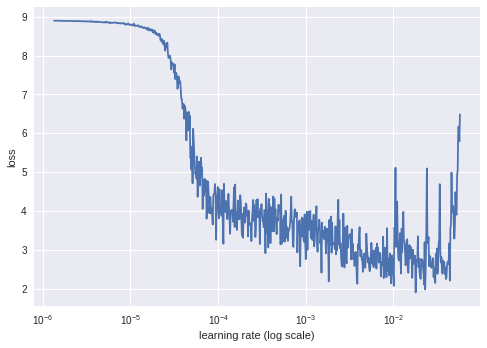

In [0]:
# model is a Keras model
lr_finder = LRFinder(model)

# Train a model with batch size 512 for 5 epochs
# with learning rate growing exponentially from 0.0001 to 1
lr_finder.find(start_lr=0.000001, end_lr=1, batch_size=32, epochs=1, num_batches=num_train_images/32)

# Plot the loss, ignore 20 batches in the beginning and 5 in the end
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

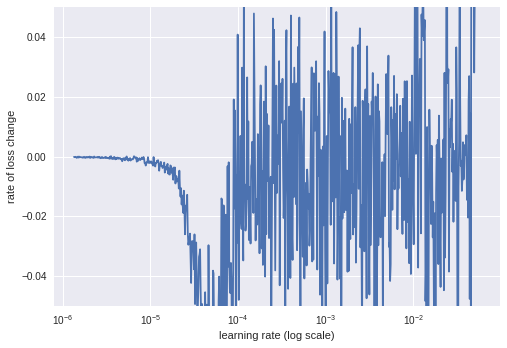

In [0]:
# Plot rate of change of the loss
# Ignore 20 batches in the beginning and 5 in the end
# Smooth the curve using simple moving average of 20 batches
# Limit the range for y axis to (-0.02, 0.01)
lr_finder.plot_loss_change(sma=20, n_skip_beginning=20, n_skip_end=5, y_lim=(-0.05, 0.05))

I ran fit_generator for 25 epochs, then for 5 epochs. What you see below is 5 epochs after 25 epochs.

If you don't want to train, download weights directly and load that and then go ahead for bleu score.
- 25th epoch: https://drive.google.com/open?id=1V0GGGVBmXL-9U63VsbXR8uavyGSyYu0o
- 30th epoch: https://drive.google.com/open?id=1g25CJT1CbTjrrIA9fASA1H18waAX665Y

In [0]:
model.fit_generator(generator=batch_generator(batch_size=32),
                    steps_per_epoch=num_train_images/32,
                    epochs=5
                    )

Epoch 1/5
938/937 [==============================] - 69s 73ms/step - loss: 1.7088
Epoch 2/5
174/937 [====>.........................] - ETA: 57s - loss: 1.6752

938/937 [==============================] - 70s 74ms/step - loss: 1.6854
Epoch 3/5
322/937 [=========>....................] - ETA: 45s - loss: 1.6822

938/937 [==============================] - 69s 74ms/step - loss: 1.6704
Epoch 4/5
397/937 [===========>..................] - ETA: 40s - loss: 1.6410

938/937 [==============================] - 69s 74ms/step - loss: 1.6564
Epoch 5/5
419/937 [============>.................] - ETA: 38s - loss: 1.6349

938/937 [==============================] - 69s 73ms/step - loss: 1.6438


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

filename = 'akshay_sanghai_caption_generator_e30.h5'
model.save(filename)
uploaded = drive.CreateFile({'title': filename})
uploaded.SetContentFile(filename)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1g25CJT1CbTjrrIA9fASA1H18waAX665Y


### 8. Calculate BLEU-1 score
 There are multiple metrics to evaluate a model. Here we use bleu score. 
 
 *token_to_word* is a dictionary which has number as key and its corresponding word. 
 
 Let's go through all the functions.
 
 *test_bleu_score*: This function calculates the bleu score on test data. For calculation of bleu score, we need references, to which our generated caption (hypothesis) (using generate_caption function) will be compared. 
 
 *generate_caption*: This function takes image name and returns the best caption for this image. First, it gets the best token (number representation of caption) (using get_best_token function) and then converts it to words using token_to_word dictionary and joins all the words.
 
 *get_best_token*: This function takes image encoding and beam size and returns the best token. The best is selected on the basis of log probability of the caption. At each iteration, we get top 3 partial captions (using get_top_next_partial function) and we stop iterating when we hit EOS ("zeosz") or max caption length for each caption.
 
 *get_top_next_partial*: This function takes current partial captions (top 3) and calculates top 3 for each partial caption. So at the end of for loop, we have 9 captions. Then we calculate top 3 and return the list. We don't calculate next word for a partial caption if it has EOS in the end or its length is max caption length.
 
 *log_softmax*: Since we didn't apply softmax in our model and depended on loss function to do that, here we do it on our own. After applying softmax, we apply log function.
 
 **This model gives a bleu score of 0.5848**

In [0]:
token_to_word = dict(zip(tokenizer.word_index.values(),
                                      tokenizer.word_index.keys()))
token_to_word[0] = ""

count = 0

def test_bleu_score():
  test_images, test_captions = get_data('Flickr8k_text/flickr_8k_test_dataset.txt')
  test_encoded_captions = tokenizer.texts_to_sequences(test_captions)
  test_captions = []
  for token in test_encoded_captions:
    caption = " ".join([token_to_word[x] for x in token])
    test_captions.append(caption)
  print(test_captions[:10])
    
  img_caption_pair = {}
  for i in range(len(test_images)):
    try:
      img_caption_pair[test_images[i]].append(test_captions[i])
    except:
      img_caption_pair[test_images[i]] = [test_captions[i]]
  
  hypothesis = []
  references = []
  
  for img_name,ref_captions in img_caption_pair.items():
    global count
    count = count +1 
    print(count)
    references.append(ref_captions)
    hypothesis.append(generate_caption(img_name))
  return bleu_score(references, hypothesis)

def generate_caption(image_name, max_tokens=39, beam_size=3):
    
    transfer_values = encoded_images[image_name]
    transfer_values = np.expand_dims(transfer_values, axis=0)
    
    token = get_best_token(transfer_values,beam_size)
    
    caption = " ".join([token_to_word[x] for x in token])
    #print("generated caption: " + caption)
    return caption
   
    
def get_best_token(transfer_values, beam_size):
  partial_tokens = get_top_first_token(transfer_values,beam_size)
  while True:
    valid_token_sum = sum([0 if (x[0][-1]==end_token or len(x[0])==39) else 1 for x in partial_tokens ])
    if(valid_token_sum==0):
      break
    partial_tokens = get_top_next_partial(partial_tokens,transfer_values,beam_size)
    
  partial_tokens.sort(key = lambda l:l[1])
  return partial_tokens[-1][0]
  
def get_top_next_partial(partial_tokens, transfer_values,beam_size):
  top_next_partial = []
  for token in partial_tokens:
    if(token[0][-1]!=end_token and len(token[0])<39):
      decoder_input_data = np.expand_dims(np.asarray(token[0]), axis=0)
      decoder_output = model.predict([transfer_values,decoder_input_data])
      next_word_no = len(token[0])
      next_token_list = decoder_output[0, next_word_no , :]
      next_token_prob_list = log_softmax(next_token_list)
      top_token_index = np.argsort(next_token_list)[-beam_size:]
      for i in range(beam_size):
        curr_token = token[0]
        curr_prob = token[-1]
        next_token_index = top_token_index[i]        
        new_prob = next_token_prob_list[next_token_index]
        top_next_partial.append([curr_token+[next_token_index],curr_prob+new_prob])
        
    else:
      top_next_partial.append(token)
  
  top_next_partial.sort(key = lambda l:l[1])
  return top_next_partial[-beam_size:]

def get_top_first_token(transfer_values, beam_size):
  top_next_partial = []
  decoder_output = model.predict([transfer_values,np.asarray([[0]])])
  next_word_no = 0
  next_token_list = decoder_output[0, next_word_no , :]
  next_token_prob_list = log_softmax(next_token_list)
  #print(next_token_prob_list)
  top_token_index = np.argsort(next_token_prob_list)[-beam_size:]
  #print(next_token_prob_list[4])
  for i in range(beam_size):
    next_token_index = top_token_index[i]        
    new_prob = next_token_prob_list[next_token_index]
    top_next_partial.append([[next_token_index],new_prob])
    
  return top_next_partial
    
def log_softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return np.log(e_x / e_x.sum())

def bleu_score(references, hypothesis):
	return nltk.translate.bleu_score.corpus_bleu(references, hypothesis)

print(test_bleu_score())


['the dogs are in the snow in front of a fence zeosz', 'the dogs play on the snow zeosz', 'two brown dogs playfully fight in the snow zeosz', 'two brown dogs wrestle in the snow zeosz', 'two dogs playing in the snow zeosz', 'a brown and white dog swimming towards some in the pool zeosz', 'a dog in a swimming pool swims toward sombody we cannot see zeosz', 'a dog swims in a pool near a person zeosz', 'small dog is paddling through the water in a pool zeosz', 'the small brown and white dog is in the pool zeosz']
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141


142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367


368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597


598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828


829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
0.5848270899009925


### 9. Different things I tried
- I started with https://github.com/anuragmishracse/caption_generator. Since this model predicts one word and not the whole caption, datapoints were high (300k) and running with batch_size of 32 or 128 takes time. I took "prepare dataset" and "few lines of bleu_score" from this project.
- Then I tried to understand how we feed input to LSTM using http://adventuresinmachinelearning.com/keras-lstm-tutorial/
- Using https://daniel.lasiman.com/post/image-captioning/, I started building the model. This guy has done hyperparameter search using http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf. I tried with multiple embedding size (128,300,512), 300 was working good for me.
- I referred https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/22_Image_Captioning.ipynb for understanding loss function. 
- I used learning rate finder code from https://github.com/surmenok/keras_lr_finder. This is based on this paper https://arxiv.org/pdf/1506.01186.pdf and I first noticed this in fast.ai couse.

### 10. What else we can try?
- Use learning rate decay
- Use Bergstra hyper-parameter search to find out optimum embedding size, learning rate.
- Right now, generate_caption function takes only one image as input, can be implemented in batch. 
- We have not used model callback and metrics for the model. The preffered metric would be bleu score, but calculating that for every epoch would take time. This can be tried as well.

### 11. References and further readings
- https://github.com/anuragmishracse/caption_generator
- https://daniel.lasiman.com/post/image-captioning/
- https://github.com/tensorflow/models/tree/master/research/im2txt/im2txt
- https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/22_Image_Captioning.ipynb
- http://adventuresinmachinelearning.com/keras-lstm-tutorial/
- https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/

**Papers**:
- Show and Tell: A Neural Image Caption Generator (https://arxiv.org/pdf/1411.4555.pdf)
- Cyclical Learning Rates for Training Neural Networks (https://arxiv.org/pdf/1506.01186.pdf)
- Random Search for Hyper-Parameter Optimization (http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)
- Densely Connected Convolutional Networks (https://arxiv.org/pdf/1608.06993.pdf)
